In [21]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


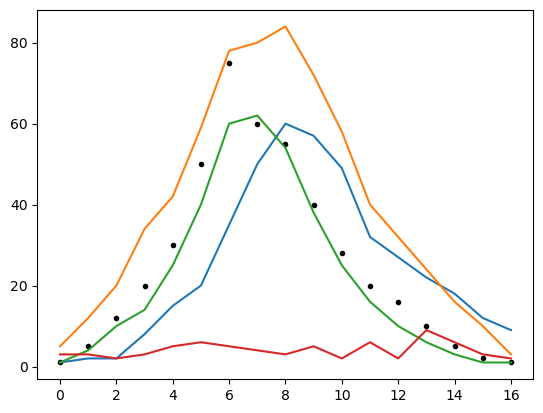

In [5]:
# generate some fake data to practice energy score on

t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
truey = [1, 5, 12, 20, 30, 50, 75, 60, 55, 40, 28, 20, 16, 10, 5, 2, 1]

traj1 = [1, 2, 2, 8, 15, 20, 35, 50, 60, 57, 49, 32, 27, 22, 18, 12, 9]
traj2 = [5, 12, 20, 34, 42, 59, 78, 80,84, 72, 58, 40, 32, 24,16, 10, 3]
traj3 = [1, 4, 10, 14, 25, 40, 60, 62, 54, 38, 25, 16, 10, 6, 3, 1, 1]
#traj4 = [3, 13, 20, 35, 58, 62, 55, 44, 32, 25, 20, 16, 12, 9, 6, 3, 2]
traj4 = [3,3, 2, 3, 5, 6, 5, 4, 3, 5, 2, 6, 2, 9, 6, 3, 2]

plt.plot(t, truey, 'k.')
plt.plot(t, traj1)
plt.plot(t, traj2)
plt.plot(t, traj3)
plt.plot(t, traj4)

In [6]:
y = truey

trajectories = {0:traj1, 1:traj2, 2:traj3, 3:traj4}

N = 4
M = len(truey)

# first term
ES1 = 0
for i in range(N):
    essqrt = 0
    for k in range(M):
        essqrt += (trajectories[i][k] - y[k])**2

    ES1 += np.sqrt(essqrt)
    
ES1 = 1/N * ES1


# second term
ES2 = 0
for i in range(N):
    for j in range(N):
        essqrt = 0
        for k in range(M):
            essqrt += (trajectories[i][k] - trajectories[j][k])**2
            
        ES2 += np.sqrt(essqrt)
ES2 = 1/(2*N**2) * ES2

ES = ES1 - ES2

In [7]:
ES

31.573030543658966

In [18]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/ensemble-square/dat/locations.csv',dtype={'location':str})

In [8]:
# download round 17 data

def pull_scenario_modeling_hub_trajectories(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    modeltype = [model, model+'-incdeath', model+'-inchosp', model+'-quantile']
    dftotal = pd.DataFrame()
    for m in modeltype:
        predictions = None
        if isinstance(dates,str):
            dates = [dates]
        for date in dates:
            url = f"https://raw.githubusercontent.com/midas-network/covid19-scenario-modeling-hub/master/data-processed/{model}/{date}-{m}"
            for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                except:
                    pass
                
        if predictions is None:
            print(f"Data for model {m} and date {dates} unavailable")
            continue

        
                
        predictions = predictions[predictions['type'] =='sample']
        predictions['quantile'] = predictions['type_id']
        
        
        dftotal = pd.concat([dftotal, predictions])  
        
        
    numweeks = list(dftotal.horizon.unique())

    start_date = list(dftotal.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-04-22") + timedelta(weeks=int(wk-1))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates})


    dftotal = dftotal.merge(dfdates, how='inner', on='horizon')
    
    #dftotal = dftotal[dftotal.target_end_date <= pd.to_datetime('2023-08-08')]
    
    return dftotal

In [192]:
#modelsall = ['Ensemble_LOP', 'Ensemble_LOP_untrimmed', 'Ensemble', 'MOBS_NEU-GLEAM_COVID']
modelsall = ['JHU_IDD-CovidSP','NotreDame-FRED', 'UTA-ImmunoSEIRS', 'UVA-adaptive', 'USC-SIkJalpha', 'UVA-EpiHiper', 'UNCC-hierbin']
dates = ['2023-04-16']

# no trajectories for Ensemble models

rd=17

for model in modelsall:
    print(model)
    predictions = pull_scenario_modeling_hub_trajectories(model,dates)
    if predictions is not None:
        predictions.to_parquet(f'./dat/{model}_rd{rd}_trajectories.pq', index=False)


JHU_IDD-CovidSP
Data for model JHU_IDD-CovidSP and date ['2023-04-16'] unavailable
NotreDame-FRED
Data for model NotreDame-FRED-incdeath and date ['2023-04-16'] unavailable
Data for model NotreDame-FRED-inchosp and date ['2023-04-16'] unavailable
Data for model NotreDame-FRED-quantile and date ['2023-04-16'] unavailable
UTA-ImmunoSEIRS
Data for model UTA-ImmunoSEIRS-incdeath and date ['2023-04-16'] unavailable
Data for model UTA-ImmunoSEIRS-inchosp and date ['2023-04-16'] unavailable
Data for model UTA-ImmunoSEIRS-quantile and date ['2023-04-16'] unavailable
UVA-adaptive
Data for model UVA-adaptive and date ['2023-04-16'] unavailable
USC-SIkJalpha
Data for model USC-SIkJalpha-incdeath and date ['2023-04-16'] unavailable
Data for model USC-SIkJalpha-inchosp and date ['2023-04-16'] unavailable
Data for model USC-SIkJalpha-quantile and date ['2023-04-16'] unavailable
UVA-EpiHiper
Data for model UVA-EpiHiper-incdeath and date ['2023-04-16'] unavailable
Data for model UVA-EpiHiper-inchosp a

In [187]:
predictions

,scenario_id,target,horizon,origin_date,location,value,type,type_id
0,A-2023-04-16,cum death,1.0,2023-04-16,01,5.274152,quantile,0.010
1,A-2023-04-16,cum death,1.0,2023-04-16,01,6.391137,quantile,0.025
2,A-2023-04-16,cum death,1.0,2023-04-16,01,7.793234,quantile,0.050
3,A-2023-04-16,cum death,1.0,2023-04-16,01,10.222658,quantile,0.100
4,A-2023-04-16,cum death,1.0,2023-04-16,01,12.817310,quantile,0.150
...,...,...,...,...,...,...,...,...
2985211,F-2023-04-16,inc hosp,104.0,2023-04-16,US,22156.675683,quantile,0.850
2985212,F-2023-04-16,inc hosp,104.0,2023-04-16,US,24842.632010,quantile,0.900
2985213,F-2023-04-16,inc hosp,104.0,2023-04-16,US,27685.068453,quantile,0.950
2985214,F-2023-04-16,inc hosp,104.0,2023-04-16,US,32704.921158,quantile,0.975


In [193]:
model = 'JHU_IDD-CovidSP'
rd=17
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')

In [13]:
a = predictions[(predictions.type_id == 1.0) & (predictions.scenario_id == 'A-2023-04-16') & \
                (predictions.location == '12') & (predictions.target == 'inc hosp')]

b = predictions[(predictions.type_id == 2.0) & (predictions.scenario_id == 'A-2023-04-16') & \
                (predictions.location == '12') & (predictions.target == 'inc hosp')]

c = predictions[(predictions.type_id == 3.0) & (predictions.scenario_id == 'A-2023-04-16') & \
                (predictions.location == '12') & (predictions.target == 'inc hosp')]


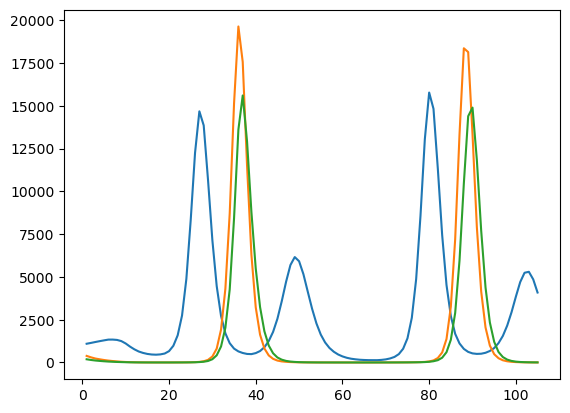

In [14]:
plt.plot(a.horizon, a['value'], '-')
plt.plot(b.horizon, b['value'], '-')
plt.plot(c.horizon, c['value'], '-')

In [17]:
incidence=True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

In [326]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

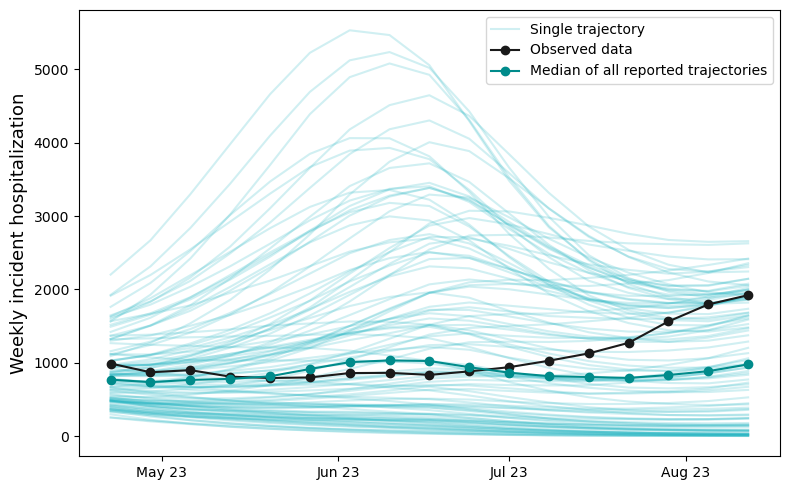

In [84]:
# plot trajectories and observations for scenario A of megaround and for Florida

fig, axes = plt.subplots(figsize=(8, 5))
start_week = Week(2023, 16)

scenario = 'B'
location = '12'
target = 'hosp'
incidence = True

if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= observations.date.unique().max()) & \
                              (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

for i in predictionsfilt.type_id.unique():
    pfilt = predictionsfilt[predictionsfilt.type_id == i]
    
    if i != predictionsfilt.type_id.unique()[-1]:
        plt.plot(pfilt.target_end_date, pfilt['value'], color = '#17B1BF', alpha = .2)
    else:
        plt.plot(pfilt.target_end_date, pfilt['value'], color = '#17B1BF', alpha = .2, label = 'Single trajectory')
    

    
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                            (observations['date'] <= pfilt.target_end_date.unique().max())]

#filter location
observations = observations[observations['location'] == location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

plt.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Observed data')
    

predfiltmed = predictionsfilt.groupby(['horizon']).median().reset_index()

plt.plot(pfilt.target_end_date, predfiltmed['value'],'-o', color = 'darkcyan',
         label = 'Median of all reported trajectories')

plt.ylabel('Weekly incident ' + target_obs, fontsize=13)
    
set_date_axis_fmt(axes)
    
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# calculate energy score

In [309]:
# raw score
modelsall = ['JHU_IDD-CovidSP','NotreDame-FRED', 'UTA-ImmunoSEIRS', 'UVA-adaptive', 'USC-SIkJalpha', 
             'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']
#modelsall = ['USC-SIkJalpha', 'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']

rd =17 

start_week = Week(2023, 16)

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()

#loclist = ['02', '01', '05', '04', '06', '08', '09']

for model in modelsall:
    print(model)
    predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')
    loclist = list(predictions.location.unique())
    loclist.remove('US')
    
    for loc in loclist:
        #energyscores[loc] = {}
        #if (model == 'UTA-ImmunoSEIRS') & (loc in ['11', '01', '02', '04', '05', '06', '08', '09']):
        #    continue
        #elif (model == 'USC-SIkJalpha') & (loc in ['01', '02', '04', '05', '06', '08', '09', '10', '12', '13', '15',
      # '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26']):
       #     continue
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])
            

            predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                                          (predictions.location == location) & \
                                          (predictions.target == 'inc ' + target)  & \
                                          (predictions.target_end_date <= observations.date.unique().max()) & \
                                          (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

            for i in predictionsfilt.type_id.unique():
                pfilt = predictionsfilt[predictionsfilt.type_id == i]


            observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                        (observations['date'] <= pfilt.target_end_date.unique().max())]

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            check = list(observations.date) == list(pfilt.target_end_date)
            if check == False:
                print('dates do not match')


            N = len(predictionsfilt.type_id.unique())
            M = len(observations)

            # first term
            ES1 = 0
            obslist = list(observations.value)
            for i in predictionsfilt.type_id.unique():
                pfilt = predictionsfilt[predictionsfilt.type_id == i]
                essqrt = 0
                for k in range(M):

                    essqrt += (list(pfilt.value)[k] - obslist[k])**2

                ES1 += np.sqrt(essqrt)

            ES1 = 1/N * ES1


            # second term
            ES2 = 0
            for i in predictionsfilt.type_id.unique():
                pfilti = predictionsfilt[predictionsfilt.type_id == i]
                for j in predictionsfilt.type_id.unique():
                    pfiltj = predictionsfilt[predictionsfilt.type_id == j]
                    essqrt = 0
                    for k in range(M):
                        essqrt += (list(pfilti.value)[k] - list(pfiltj.value)[k])**2

                    ES2 += np.sqrt(essqrt)
            ES2 = 1/(2*N**2) * ES2

            ES = ES1 - ES2
            
            if int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc 

            #energyscores[loc][scenario] = ES


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                  'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])
        
energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   

            
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')


JHU_IDD-CovidSP
NotreDame-FRED
UTA-ImmunoSEIRS
UVA-adaptive
USC-SIkJalpha
UVA-EpiHiper
UNCC-hierbin
MOBS_NEU-GLEAM_COVID


In [382]:
# raw score
modelsall = ['JHU_IDD-CovidSP','NotreDame-FRED', 'UTA-ImmunoSEIRS', 'UVA-adaptive', 'USC-SIkJalpha', 
             'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']

rd =17 

start_week = Week(2023, 16)

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()

#loclist = ['02', '01', '05', '04', '06', '08', '09']

for model in modelsall:
    print(model)
    predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')
    loclist = list(predictions.location.unique())
    loclist.remove('US')
    
    for loc in loclist:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])
            

            predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                                          (predictions.location == location) & \
                                          (predictions.target == 'inc ' + target)  & \
                                          (predictions.target_end_date <= observations.date.unique().max()) & \
                                          (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

            for i in predictionsfilt.type_id.unique():
                pfilt = predictionsfilt[predictionsfilt.type_id == i]


            observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                        (observations['date'] <= pfilt.target_end_date.unique().max())]

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            check = list(observations.date) == list(pfilt.target_end_date)
            if check == False:
                print('dates do not match')


            N = len(predictionsfilt.type_id.unique())
            M = len(observations)

            # first term
            observations['target_end_date'] = observations['date']
            pfilt = predictionsfilt.merge(observations, how='left', on=['location', 'target_end_date'])
            pfilt['diff_sq']=(pfilt.value_x - pfilt.value_y)**2

            ES1 = 1/N*sum(np.sqrt(np.array(pfilt.groupby(['type_id']).sum()['diff_sq'])))
            
            

            # second term
            
            cross = predictionsfilt.merge(predictionsfilt, how='cross')
            crossfilt = cross.loc[(cross['target_end_date_x'] == cross['target_end_date_y']) ]
            
            crossfilt['diff_sq'] = (crossfilt.value_x - crossfilt.value_y)**2
            ES2 = 1/(2*N**2) * sum(np.sqrt(np.array(crossfilt.groupby(['type_id_x', 'type_id_y']).sum()['diff_sq'])))
            

            ES = ES1 - ES2
            
            if int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc 

            #energyscores[loc][scenario] = ES


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                  'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])
        
energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   

            
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')

energyscoresdf.to_pickle('energyscore_raw_hosp_rd17_models.pkl')



MOBS_NEU-GLEAM_COVID


In [383]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,MOBS_NEU-GLEAM_COVID,Scenario A,12,3526.201073,hosp,FL,Florida,21477737


In [307]:
energyscoresdf1 = energyscoresdf

In [306]:
ll = []
for l in a.location.unique():
    if l not in energyscoresdf[energyscoresdf.Model == 'JHU_IDD-CovidSP'].location.unique():
        ll.append(l)
        
ll


['02', '01', '05', '04', '06', '08', '09', 'US']

In [311]:
energyscoresdf2 =  energyscoresdf

In [313]:
energyscoresdf = pd.concat([energyscoresdf2, energyscoresdf1])

In [317]:
energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,JHU_IDD-CovidSP,Scenario A,2,47.726550,hosp,AK,Alaska,731545
1,JHU_IDD-CovidSP,Scenario B,2,75.218001,hosp,AK,Alaska,731545
2,JHU_IDD-CovidSP,Scenario C,2,47.783864,hosp,AK,Alaska,731545
3,JHU_IDD-CovidSP,Scenario D,2,77.904604,hosp,AK,Alaska,731545
4,JHU_IDD-CovidSP,Scenario E,2,53.174328,hosp,AK,Alaska,731545
...,...,...,...,...,...,...,...,...
2089,MOBS_NEU-GLEAM_COVID,Scenario B,56,36.046289,hosp,WY,Wyoming,578759
2090,MOBS_NEU-GLEAM_COVID,Scenario C,56,40.088233,hosp,WY,Wyoming,578759
2091,MOBS_NEU-GLEAM_COVID,Scenario D,56,30.833566,hosp,WY,Wyoming,578759
2092,MOBS_NEU-GLEAM_COVID,Scenario E,56,42.852647,hosp,WY,Wyoming,578759


In [195]:
energyscoresdf = pd.DataFrame()
for loc in energyscores.keys():
    for scenario in energyscores[loc].keys():
        score = energyscores[loc][scenario]
        
        newrow = pd.DataFrame({'Label': 'Scenario '+scenario, 'location':loc, 'energyscore':score, 
                              'target':target}, index=[0])
        
        energyscoresdf = pd.concat([energyscoresdf, newrow])
        
energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])    
            
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')
    


In [318]:
energyscoresdf.to_pickle('energyscore_raw_hosp_rd17_all.pkl')


In [384]:
p = pd.read_pickle('energyscore_raw_hosp_rd17_all.pkl')

In [386]:
p[(p.Model == 'MOBS_NEU-GLEAM_COVID') & (p.location == '12')]

,Model,Label,location,energyscore,target,abbreviation,location_name,population
132,MOBS_NEU-GLEAM_COVID,Scenario A,12,2544.490762,hosp,FL,Florida,21477737
133,MOBS_NEU-GLEAM_COVID,Scenario B,12,1628.284252,hosp,FL,Florida,21477737
134,MOBS_NEU-GLEAM_COVID,Scenario C,12,2145.531742,hosp,FL,Florida,21477737
135,MOBS_NEU-GLEAM_COVID,Scenario D,12,1644.960349,hosp,FL,Florida,21477737
136,MOBS_NEU-GLEAM_COVID,Scenario E,12,2459.472969,hosp,FL,Florida,21477737
137,MOBS_NEU-GLEAM_COVID,Scenario F,12,1601.800618,hosp,FL,Florida,21477737


In [ ]:
#faster way

In [42]:
# raw score
modelsall = ['JHU_IDD-CovidSP','NotreDame-FRED', 'UTA-ImmunoSEIRS', 'UVA-adaptive', 'USC-SIkJalpha', 
             'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']

modelsall = [ 'MOBS_NEU-GLEAM_COVID']

rd =17 

start_week = Week(2023, 16)

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()

#loclist = ['02', '01', '05', '04', '06', '08', '09']

for model in modelsall:
    print(model)
    predictions = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/ensemble-square/dat/{model}_rd{rd}_trajectories.pq')
    loclist = list(predictions.location.unique())
    loclist.remove('US')
    
    for loc in loclist:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        
            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/ensemble-square/dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])
            

            predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                                          (predictions.location == location) & \
                                          (predictions.target == 'inc ' + target)  & \
                                          (predictions.target_end_date <= observations.date.unique().max()) & \
                                          (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

            for i in predictionsfilt.type_id.unique():
                pfilt = predictionsfilt[predictionsfilt.type_id == i]


            observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                        (observations['date'] <= pfilt.target_end_date.unique().max())]

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)

            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt.type_id == i].value) for i in predictionsfilt.type_id.unique()]
            
            ES = energyscore(np.array(X),y)
            
            if int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc 

            #energyscores[loc][scenario] = ES


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                                  'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])
        
energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   

            
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')

#energyscoresdf.to_pickle('energyscore_raw_hosp_rd17_models.pkl')



MOBS_NEU-GLEAM_COVID


# normalized energy score

In [339]:
modelsall = ['JHU_IDD-CovidSP','NotreDame-FRED', 'UTA-ImmunoSEIRS', 'UVA-adaptive', 'USC-SIkJalpha', 
             'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']

#modelsall = ['USC-SIkJalpha', 'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']

rd=17


start_week = Week(2023, 16)

#loclist = list(predictions.location.unique())
#loclist.remove('US')
loclist = ['02', '01', '05', '04', '06', '08', '09']

norm_energyscoresdf = pd.DataFrame()
#for loc in ['12']:
for model in modelsall:
    print(model)
    predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')
   # loclist = list(predictions.location.unique())
   # loclist.remove('US')
    for loc in loclist:

       # if (model == 'UTA-ImmunoSEIRS') & (loc in ['11']):
        #    continue
       # elif (model == 'USC-SIkJalpha') & (loc not in ['55', '56']):
       #     continue
            
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            #scenario = 'B'
            location = loc
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs

            observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
            observations['date'] = pd.to_datetime(observations['date'])

            predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-04-16') & \
                                          (predictions.location == location) & \
                                          (predictions.target == 'inc ' + target)  & \
                                          (predictions.target_end_date <= observations.date.unique().max()) & \
                                          (predictions.target_end_date >= pd.to_datetime(start_week.startdate()))]

            for i in predictionsfilt.type_id.unique():
                pfilt = predictionsfilt[predictionsfilt.type_id == i]


            observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                        (observations['date'] <= pfilt.target_end_date.unique().max())]

            #filter location
            observations = observations[observations['location'] == location]

            #aggregate to weekly
            observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

            #transform to Observation object
            observations = Observations(observations)


            check = list(observations.date) == list(pfilt.target_end_date)
            if check == False:
                print('dates do not match')


            N = len(predictionsfilt.type_id.unique())
            M = len(observations)

            # first term
            ES1 = 0
            obslist = list(observations.value)
            for i in predictionsfilt.type_id.unique():
                pfilt = predictionsfilt[predictionsfilt.type_id == i]
                essqrt = 0
                for k in range(M):

                    essqrt += ((list(pfilt.value)[k] - obslist[k])/obslist[k])**2

                ES1 += np.sqrt(essqrt)

            ES1 = 1/N * ES1


            # second term
            ES2 = 0
            for i in predictionsfilt.type_id.unique():
                pfilti = predictionsfilt[predictionsfilt.type_id == i]
                for j in predictionsfilt.type_id.unique():
                    pfiltj = predictionsfilt[predictionsfilt.type_id == j]
                    essqrt = 0
                    for k in range(M):
                        essqrt += ((list(pfilti.value)[k] - list(pfiltj.value)[k])/obslist[k])**2

                    ES2 += np.sqrt(essqrt)
            ES2 = 1/(2*N**2) * ES2

            ES = ES1 - ES2

            if int(loc) <10:
                loc_conv = loc[1]
            else:
                loc_conv = loc 

            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+scenario, 'location':loc_conv, 
                                   'energyscore':ES, 'target':target}, index=[0])

            norm_energyscoresdf = pd.concat([norm_energyscoresdf, newrow])
        
norm_energyscoresdf = norm_energyscoresdf.reset_index()
norm_energyscoresdf = norm_energyscoresdf.drop(columns=['index'])    
            
norm_energyscoresdf = pd.merge(norm_energyscoresdf, locations, how = 'inner', on = 'location')


In [171]:
norm_energyscoresdfmobs = norm_energyscoresdf
energyscoresdfmobs = energyscoresdf

In [237]:
norm_energyscoresdf.to_pickle('energyscore_norm_hosp_rd17_all.pkl')

In [341]:
norm_energyscoresdf

,Model,Label,location,energyscore,target,abbreviation,location_name,population
0,JHU_IDD-CovidSP,Scenario A,2,2.332168,hosp,AK,Alaska,731545
1,JHU_IDD-CovidSP,Scenario B,2,3.786472,hosp,AK,Alaska,731545
2,JHU_IDD-CovidSP,Scenario C,2,2.378810,hosp,AK,Alaska,731545
3,JHU_IDD-CovidSP,Scenario D,2,3.806425,hosp,AK,Alaska,731545
4,JHU_IDD-CovidSP,Scenario E,2,2.618294,hosp,AK,Alaska,731545
...,...,...,...,...,...,...,...,...
2089,MOBS_NEU-GLEAM_COVID,Scenario B,56,2.375830,hosp,WY,Wyoming,578759
2090,MOBS_NEU-GLEAM_COVID,Scenario C,56,2.653948,hosp,WY,Wyoming,578759
2091,MOBS_NEU-GLEAM_COVID,Scenario D,56,2.032620,hosp,WY,Wyoming,578759
2092,MOBS_NEU-GLEAM_COVID,Scenario E,56,2.838340,hosp,WY,Wyoming,578759


In [340]:
norm_energyscoresdf = pd.read_pickle('energyscore_norm_hosp_rd17_all.pkl')

# Compare to WIS

In [198]:
wisdf = pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 

wisdf = wisdf.rename(columns={'Location':'location_name'})

wisdf = wisdf[wisdf.Model == 'JHU_IDD-CovidSP']

In [148]:
wisdf

,Model,WIS,location_name,Label,Target
21,MOBS_NEU-GLEAM_COVID,56.119092,Alabama,Scenario A,hosp
22,MOBS_NEU-GLEAM_COVID,47.513382,Alabama,Scenario B,hosp
23,MOBS_NEU-GLEAM_COVID,57.532292,Alabama,Scenario C,hosp
24,MOBS_NEU-GLEAM_COVID,47.612094,Alabama,Scenario D,hosp
25,MOBS_NEU-GLEAM_COVID,57.057019,Alabama,Scenario E,hosp
...,...,...,...,...,...
2816,MOBS_NEU-GLEAM_COVID,8.725747,Wyoming,Scenario C,hosp
2817,MOBS_NEU-GLEAM_COVID,6.247210,Wyoming,Scenario D,hosp
2818,MOBS_NEU-GLEAM_COVID,8.558154,Wyoming,Scenario E,hosp
2819,MOBS_NEU-GLEAM_COVID,6.293895,Wyoming,Scenario F,hosp


In [199]:
allscores = pd.merge(energyscoresdf, wisdf, how='inner', on=['location_name', 'Label'])

In [200]:
allscoresjhu = allscores

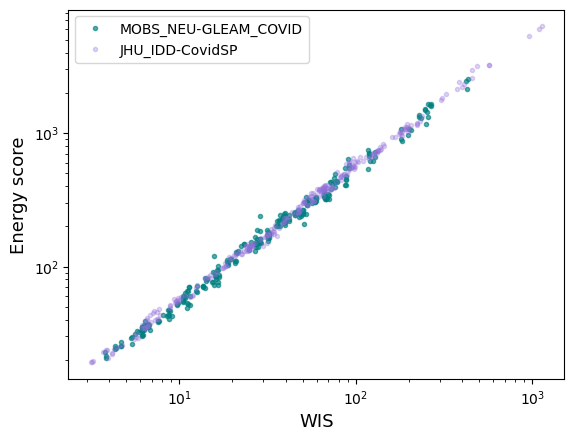

In [212]:
plt.loglog(allscoresmobs.WIS, allscoresmobs.energyscore,'.', color = 'teal', alpha=.65, label = 'MOBS_NEU-GLEAM_COVID')
plt.loglog(allscoresjhu.WIS, allscoresjhu.energyscore,'.', color = 'mediumpurple', alpha=.3, label = 'JHU_IDD-CovidSP')

plt.xlabel('WIS', fontsize=13)
plt.ylabel('Energy score', fontsize=13)


plt.legend()

plt.show()
# un normalized for both

# cannot compare one normalized, another unnormalized
# either both WIS and energy score must be normalized to account for magnitude differences or both are just raw scores

# WIS and energy score are highly correlated

In [374]:
w = wisdf[wisdf.Model == 'UNCC-hierbin']

esmod = es[es.Model == 'UNCC-hierbin']

allscores = pd.merge(esmod, w, how='inner', on=['location_name', 'Label'])
allscores

,Model_x,Label,location,energyscore,target,abbreviation,location_name,population,Model_y,WIS,Target


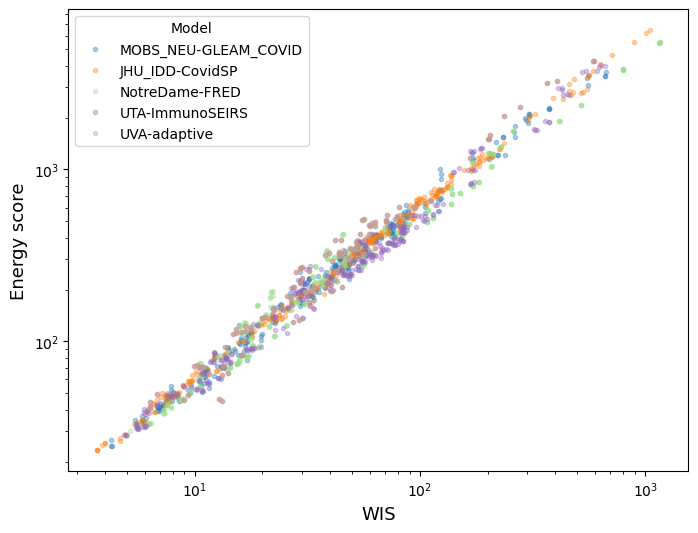

In [436]:
# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17
es = pd.read_pickle('energyscore_raw_hosp_rd17_models.pkl')

wisdf = pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 
wisdf = wisdf.rename(columns={'Location':'location_name'})

cmap = plt.get_cmap('tab20', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['MOBS_NEU-GLEAM_COVID', 'JHU_IDD-CovidSP', 'NotreDame-FRED',
       'UTA-ImmunoSEIRS', 'UVA-adaptive']:
    wis = wisdf[wisdf.Model == model]

    esmod = es[es.Model == model]

    allscores = pd.merge(esmod, wis, how='inner', on=['location_name', 'Label'])


    plt.loglog(allscores.WIS, allscores.energyscore,'.', alpha=.35,color = colors[i], label = model)
    
    i+=1
    
plt.xlabel('WIS', fontsize=13)
plt.ylabel('Energy score', fontsize=13)


plt.legend(title='Model')

plt.savefig('energyscore_wis_raw.pdf')
plt.show()


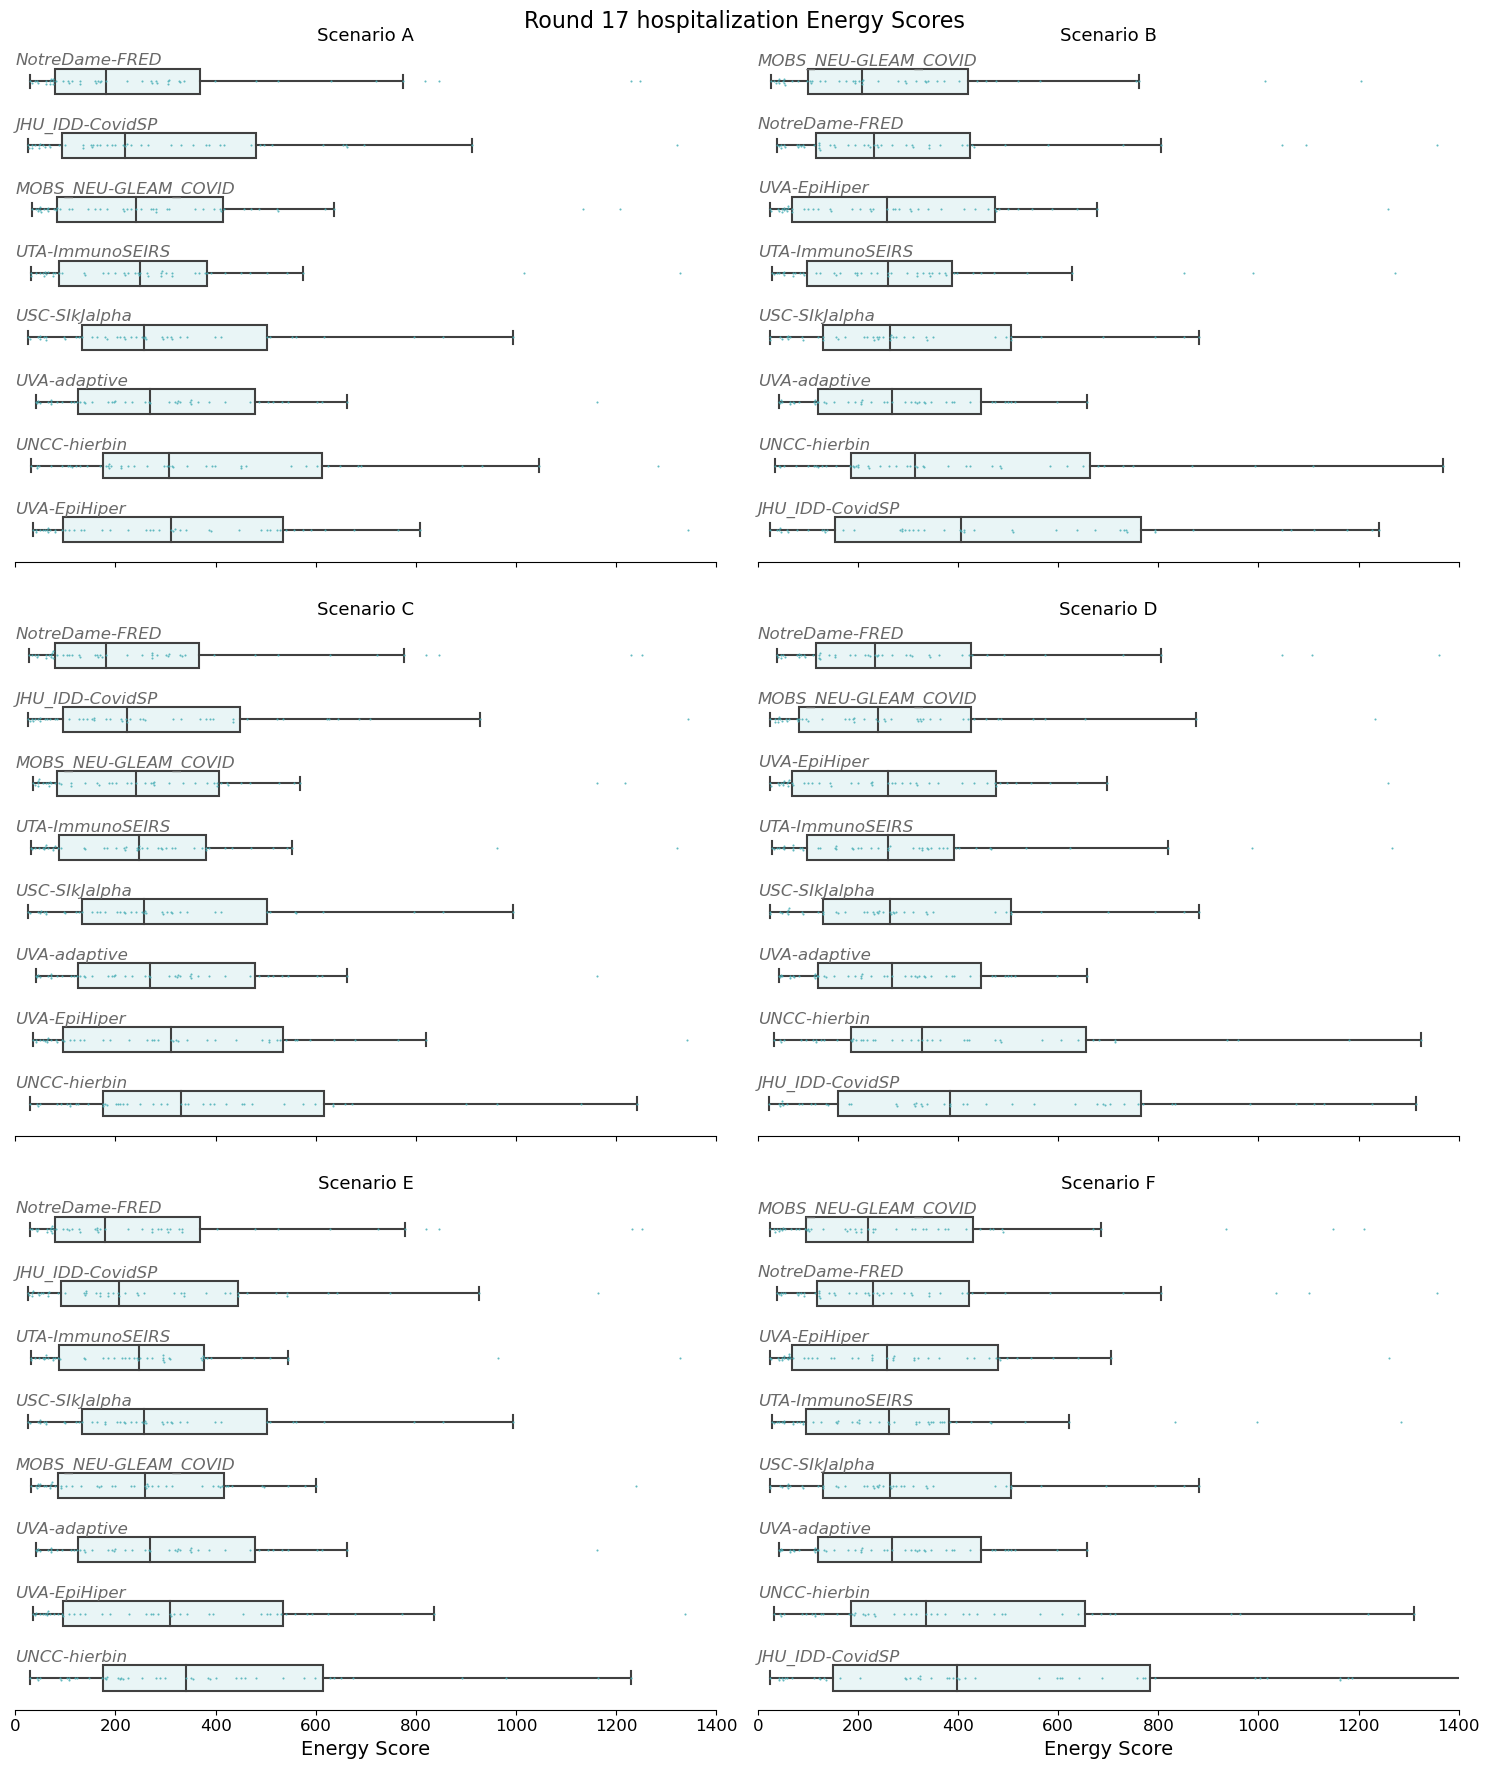

In [437]:
fig = plt.subplots(3,2,figsize=(15,18), sharex=True)

j=1
for scen in ['A', 'B', 'C', 'D', 'E', 'F']:

    ax = plt.subplot(3,2,j)
    
    esdf = es[es.Label == 'Scenario ' + scen]

    my_order = esdf.groupby(by=['Model'])['energyscore'].median().sort_values(ascending=True).index
    g = sns.boxplot(x='energyscore', y='Model', data=esdf,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='energyscore', y='Model', data=esdf,order=my_order,color = "#49AFB7",alpha = .85,size=1.5, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Energy Score', fontsize=14)
        plt.xticks(fontsize=12)
    else:
        g.set(xlabel=' ')


    a = 0
    for mod in list(my_order):
        plt.text(.01,a-.25, mod, fontsize=12, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.xlim([0,1400]) # cuts off some outliers

    plt.title(r'Scenario '+scen, fontsize=13)
    
    j+=1

plt.suptitle('Round 17 hospitalization Energy Scores', fontsize=16)
plt.tight_layout()
#plt.savefig('energyscore_dist_hosp_rd17.pdf')
plt.show()


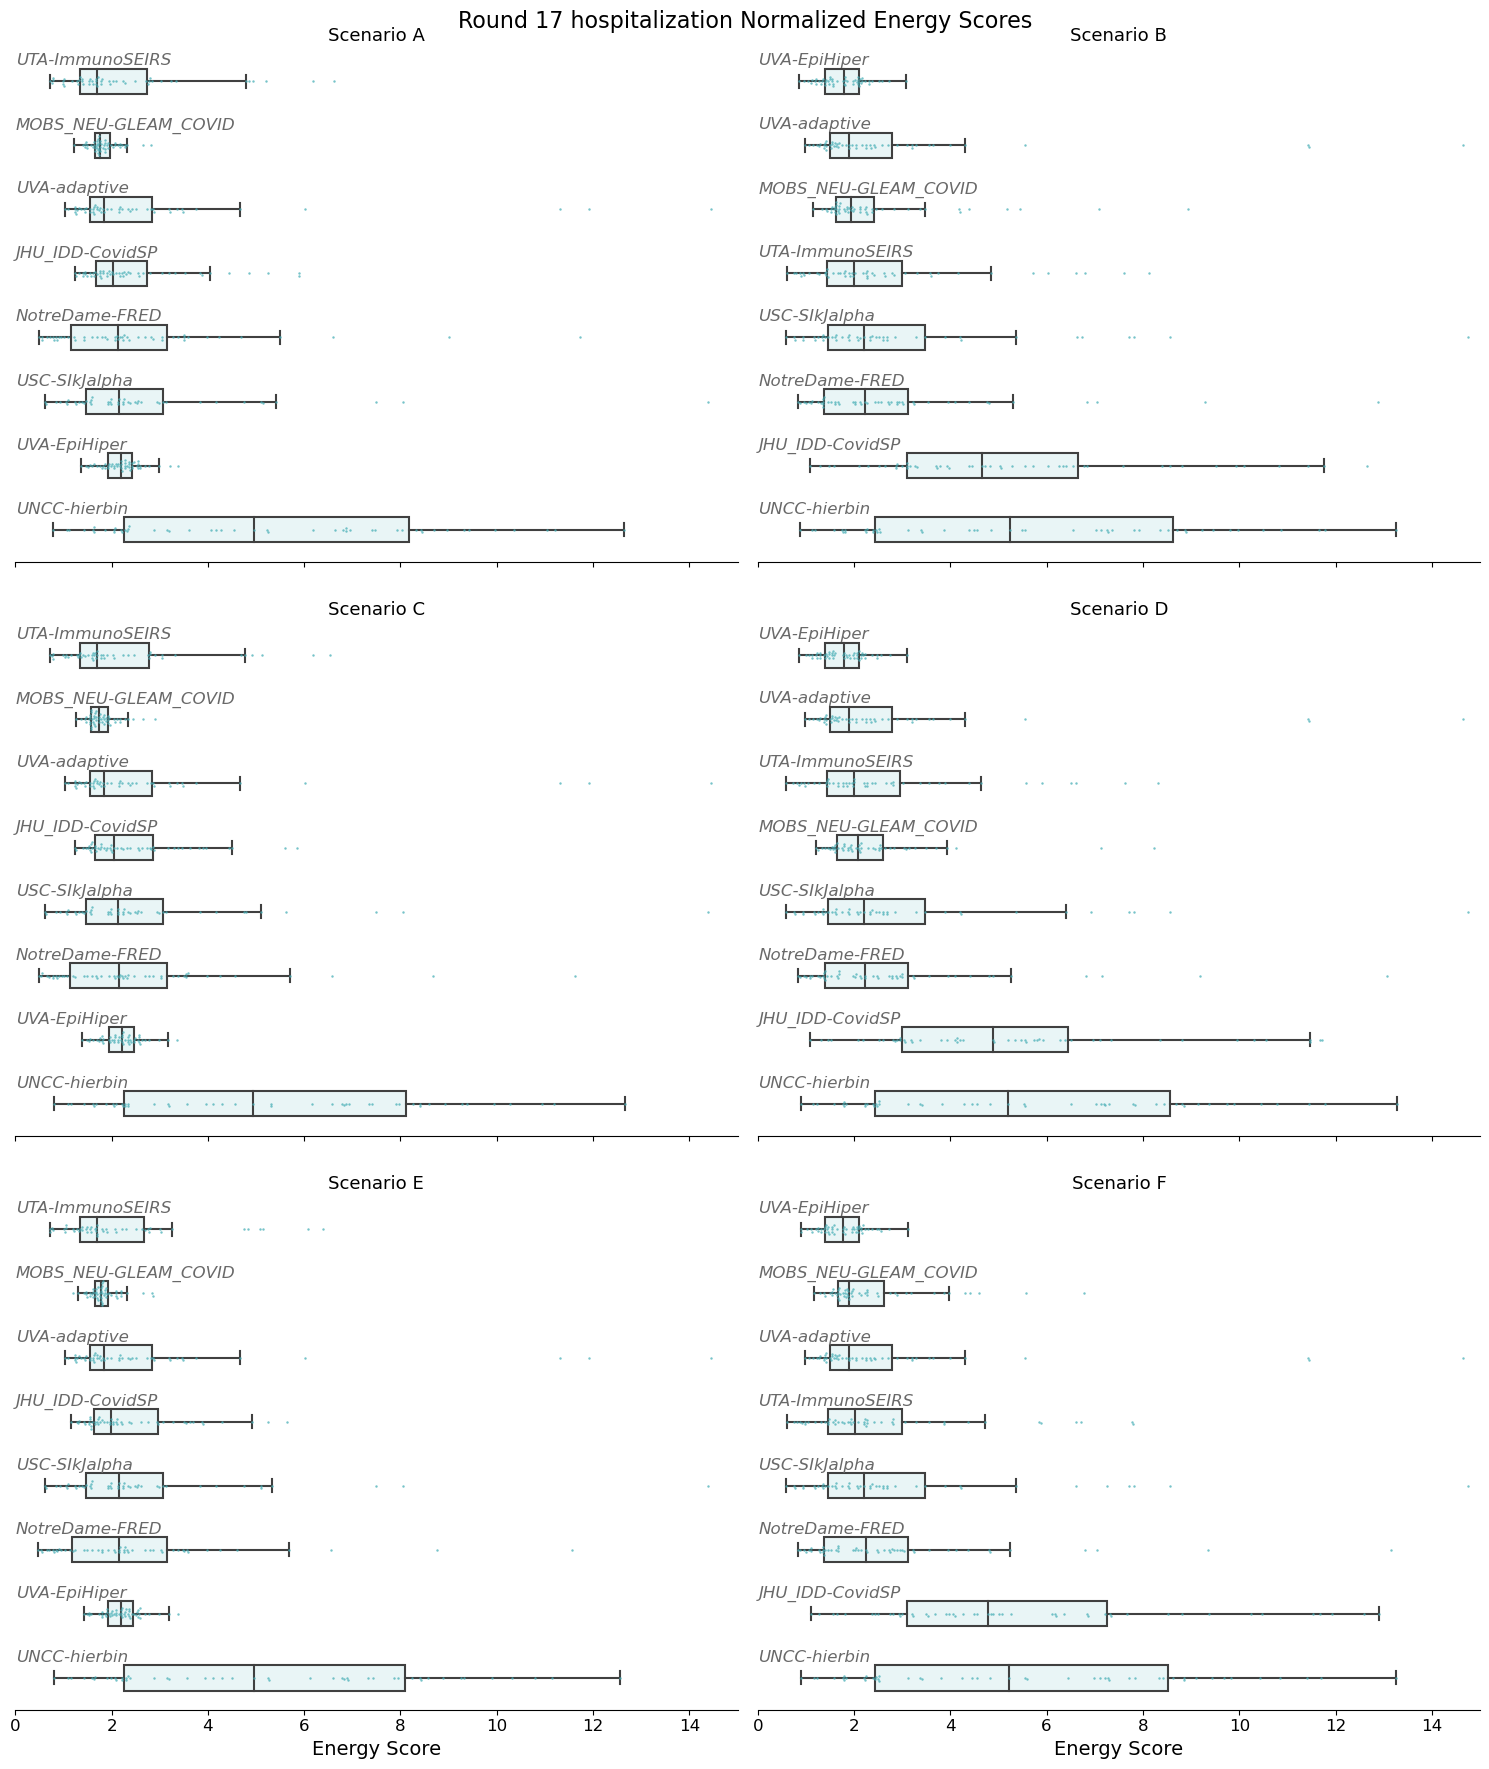

In [386]:
fig = plt.subplots(3,2,figsize=(15,18), sharex=True)
norm_energyscoresdf = pd.read_pickle('energyscore_norm_hosp_rd17_all.pkl')
j=1
for scen in ['A', 'B', 'C', 'D', 'E', 'F']:

    ax = plt.subplot(3,2,j)
    
    esdf = norm_energyscoresdf[norm_energyscoresdf.Label == 'Scenario ' + scen]

    my_order = esdf.groupby(by=['Model'])['energyscore'].median().sort_values(ascending=True).index
    g = sns.boxplot(x='energyscore', y='Model', data=esdf,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='energyscore', y='Model', data=esdf,order=my_order,color = "#49AFB7",alpha = .75,size=1.75, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Energy Score', fontsize=14)
        plt.xticks(fontsize=12)
    else:
        g.set(xlabel=' ')


    a = 0
    for mod in list(my_order):
        plt.text(.01,a-.25, mod, fontsize=12, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.xlim([0,15]) # cuts off some outliers

    plt.title(r'Scenario '+scen, fontsize=13)
    
    j+=1

plt.suptitle('Round 17 hospitalization Normalized Energy Scores', fontsize=16)
plt.tight_layout()
#plt.savefig('norm_energyscore_dist_hosp_rd17.pdf')
plt.show()

In [379]:
wisdfavg = pd.read_pickle(f'megaround_wis_norm_{target}_rd{rd}_scenarios_avg.pkl')

In [380]:
wisdfavg

,Model,Location,Label,Round,Target,WISavg
0,Ensemble_LOP,Alabama,Scenario A,17,hosp,0.987560
1,Ensemble_LOP_untrimmed,Alabama,Scenario A,17,hosp,1.053315
2,Ensemble,Alabama,Scenario A,17,hosp,0.871275
3,MOBS_NEU-GLEAM_COVID,Alabama,Scenario A,17,hosp,2.080647
4,JHU_IDD-CovidSP,Alabama,Scenario A,17,hosp,2.036692
...,...,...,...,...,...,...
2851,MOBS_NEU-GLEAM_COVID,Wyoming,Median aggregate,17,hosp,2.265431
2852,JHU_IDD-CovidSP,Wyoming,Median aggregate,17,hosp,1.677450
2853,NotreDame-FRED,Wyoming,Median aggregate,17,hosp,2.656221
2854,UTA-ImmunoSEIRS,Wyoming,Median aggregate,17,hosp,2.916557


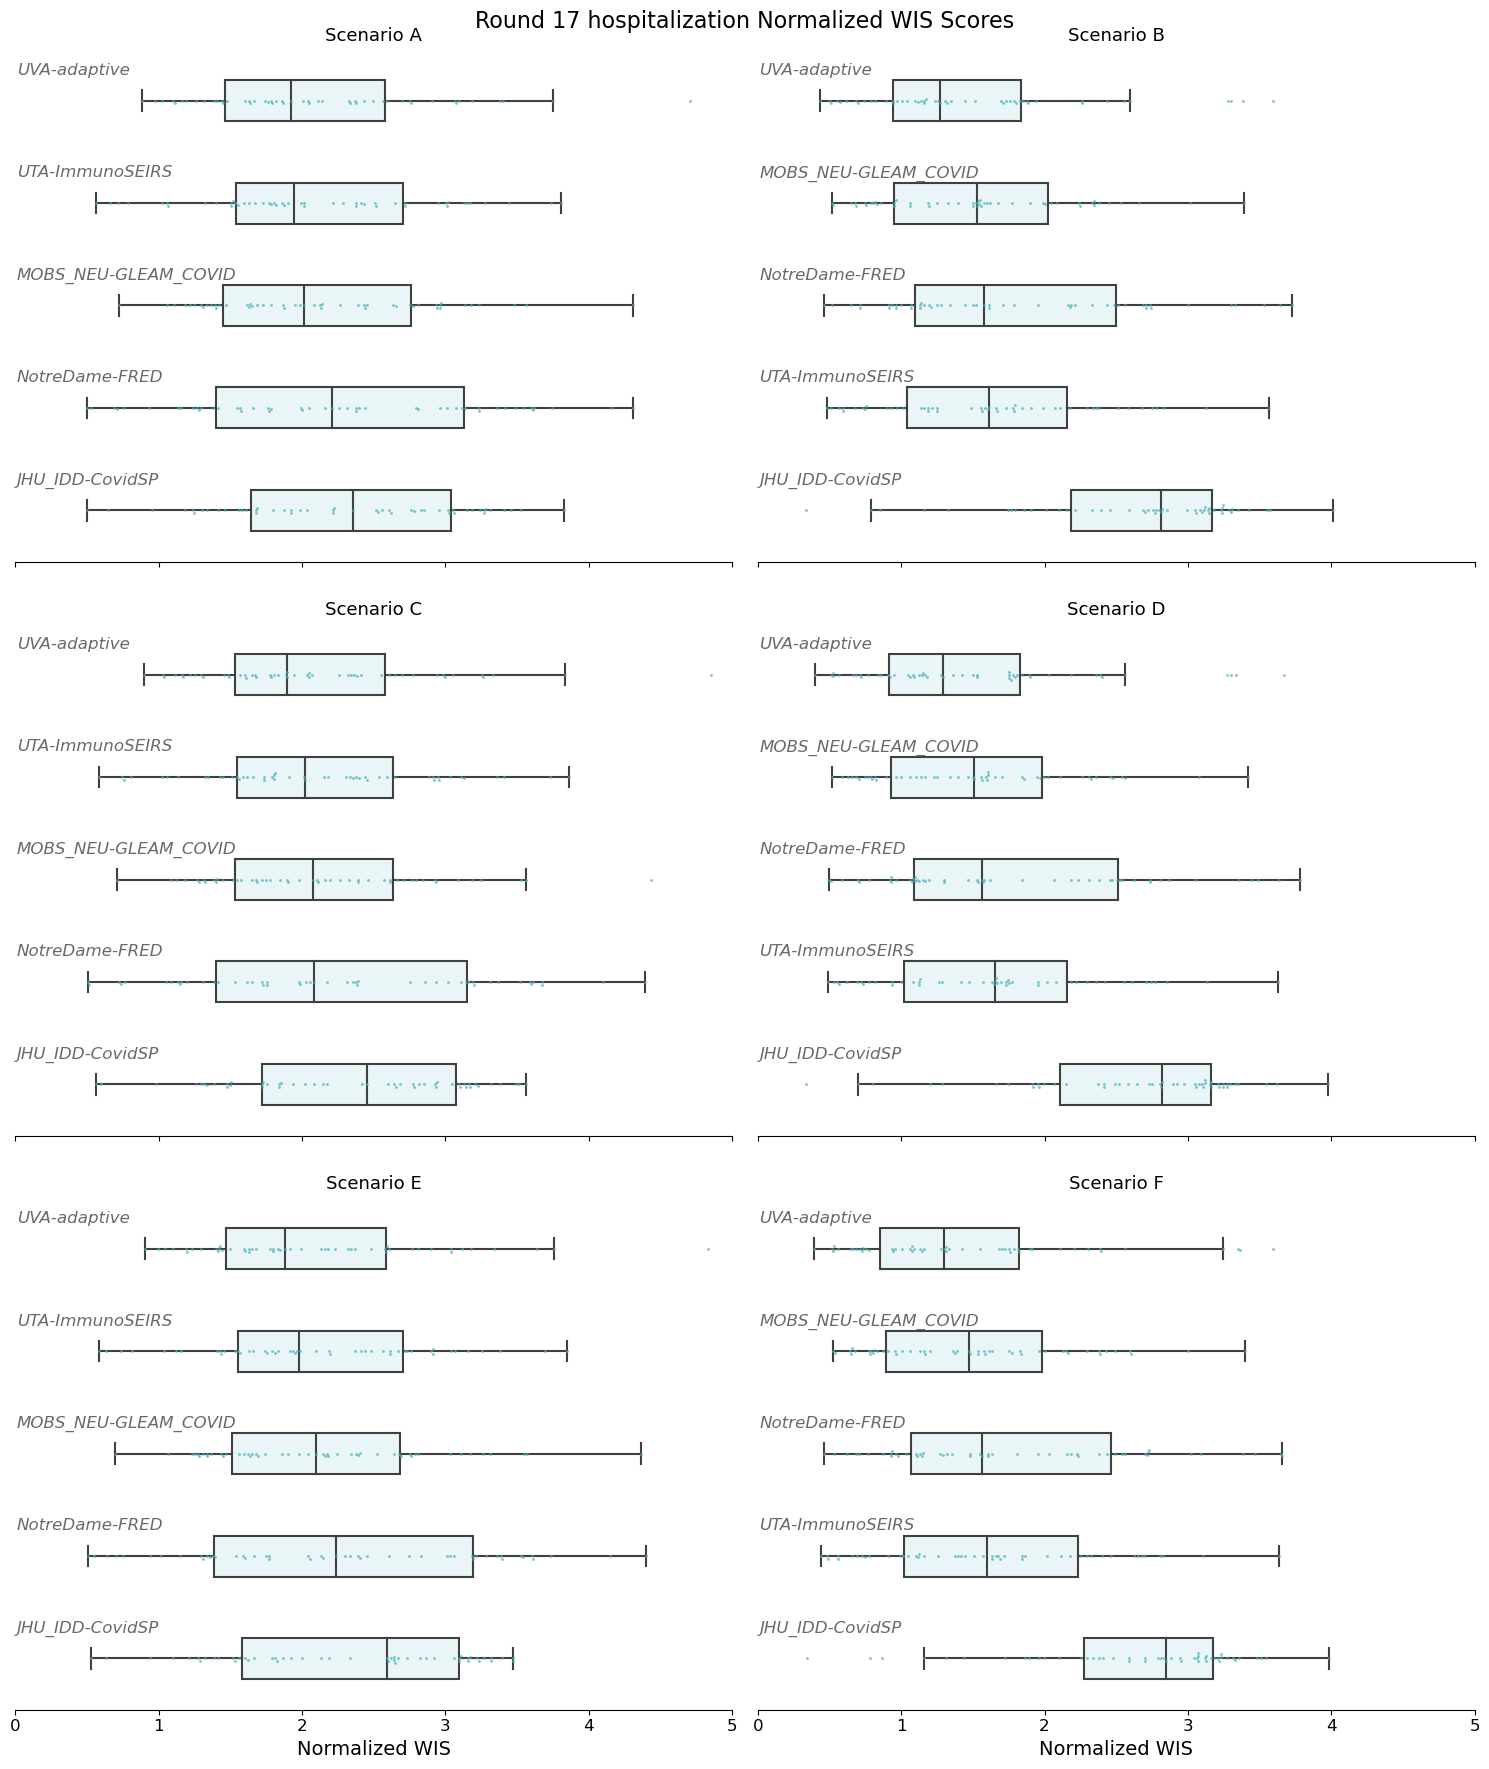

In [385]:
fig = plt.subplots(3,2,figsize=(15,18), sharex=True)

j=1

wisdfavg = wisdfavg[(wisdfavg.Model != 'Ensemble_LOP_untrimmed') & (wisdfavg.Model != 'Ensemble_LOP') & \
        (wisdfavg.Model != 'Ensemble')]

for scen in ['A', 'B', 'C', 'D', 'E', 'F']:

    ax = plt.subplot(3,2,j)
    
    df = wisdfavg[wisdfavg.Label == 'Scenario ' + scen]

    my_order = df.groupby(by=['Model'])['WISavg'].median().sort_values(ascending=True).index
    g = sns.boxplot(x='WISavg', y='Model', data=df,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='WISavg', y='Model', data=df,order=my_order,color = "#49AFB7",alpha = .75,size=2, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Normalized WIS', fontsize=14)
        plt.xticks(fontsize=12)
    else:
        g.set(xlabel=' ')


    a = 0
    for mod in list(my_order):
        plt.text(.01,a-.25, mod, fontsize=12, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.xlim([0,5]) # cuts off some outliers

    plt.title(r'Scenario '+scen, fontsize=13)
    
    j+=1

plt.suptitle('Round 17 hospitalization Normalized WIS Scores', fontsize=16)
plt.tight_layout()
plt.savefig('norm_wis_dist_hosp_rd17.pdf')
plt.show()

In [400]:
norm_energyscoresdf = pd.read_pickle('energyscore_norm_hosp_rd17_all.pkl')
wisdfavg = pd.read_pickle(f'megaround_wis_norm_{target}_rd{rd}_scenarios_avg.pkl')
wisdfavg = wisdfavg[(wisdfavg.Model != 'Ensemble_LOP_untrimmed') & (wisdfavg.Model != 'Ensemble_LOP') & \
        (wisdfavg.Model != 'Ensemble')]

norm_energyscoresdf = norm_energyscoresdf.rename(columns={'energyscore':'value'})
norm_energyscoresdf['Score'] = 'Normalized Energy Score'
wisdfavg = wisdfavg.rename(columns={'WISavg':'value'})
wisdfavg['Score'] = 'Normalized WIS'

allscore = pd.concat([norm_energyscoresdf, wisdfavg])

allscore = allscore[(allscore.Model != 'UNCC-hierbin') & (allscore.Model != 'USC-SIkJalpha') & \
                    (allscore.Model != 'UVA-EpiHiper')]

In [392]:
allscore

,Model,Label,location,value,target,abbreviation,location_name,population,Score,Location,Round,Target
0,JHU_IDD-CovidSP,Scenario A,2,2.332168,hosp,AK,Alaska,731545.0,Normalized Energy Score,NaN,NaN,NaN
1,JHU_IDD-CovidSP,Scenario B,2,3.786472,hosp,AK,Alaska,731545.0,Normalized Energy Score,NaN,NaN,NaN
2,JHU_IDD-CovidSP,Scenario C,2,2.378810,hosp,AK,Alaska,731545.0,Normalized Energy Score,NaN,NaN,NaN
3,JHU_IDD-CovidSP,Scenario D,2,3.806425,hosp,AK,Alaska,731545.0,Normalized Energy Score,NaN,NaN,NaN
4,JHU_IDD-CovidSP,Scenario E,2,2.618294,hosp,AK,Alaska,731545.0,Normalized Energy Score,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2851,MOBS_NEU-GLEAM_COVID,Median aggregate,NaN,2.265431,NaN,NaN,NaN,NaN,Normalized WIS,Wyoming,17.0,hosp
2852,JHU_IDD-CovidSP,Median aggregate,NaN,1.677450,NaN,NaN,NaN,NaN,Normalized WIS,Wyoming,17.0,hosp
2853,NotreDame-FRED,Median aggregate,NaN,2.656221,NaN,NaN,NaN,NaN,Normalized WIS,Wyoming,17.0,hosp
2854,UTA-ImmunoSEIRS,Median aggregate,NaN,2.916557,NaN,NaN,NaN,NaN,Normalized WIS,Wyoming,17.0,hosp


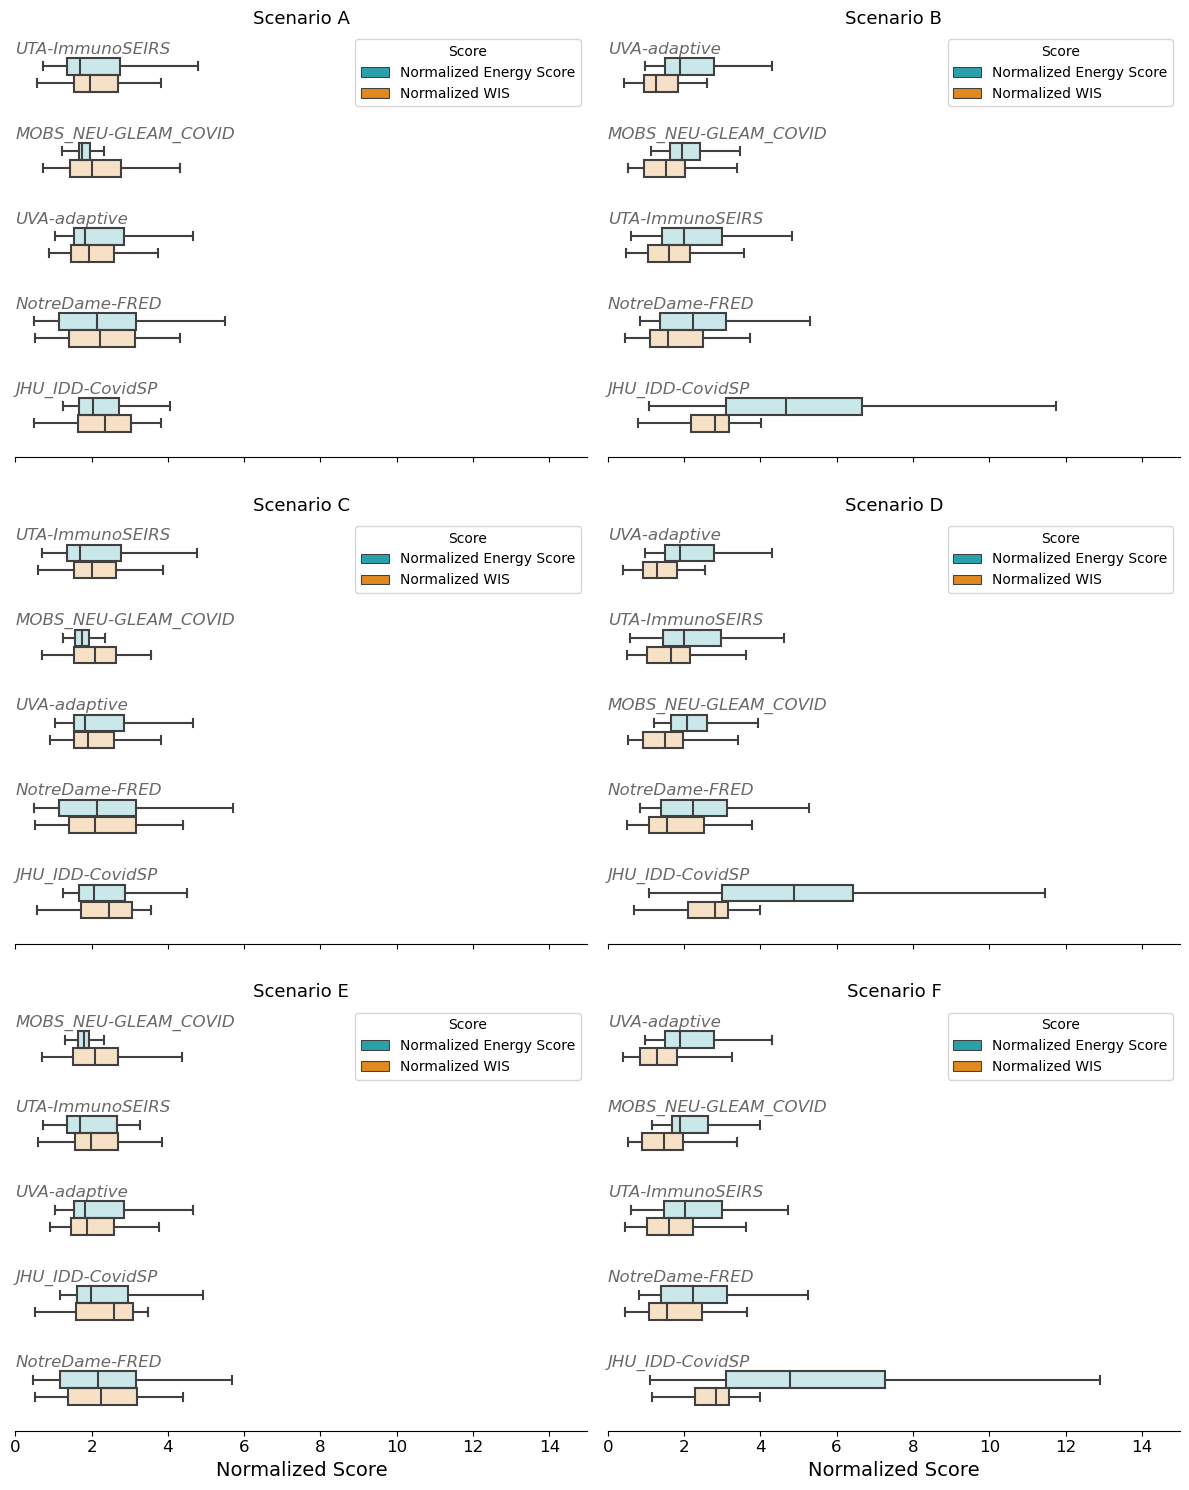

In [409]:
fig = plt.subplots(3,2,figsize=(12,15), sharex=True)
norm_energyscoresdf = pd.read_pickle('energyscore_norm_hosp_rd17_all.pkl')
j=1
for scen in ['A', 'B', 'C', 'D', 'E', 'F']:

    ax = plt.subplot(3,2,j)
    
    df = allscore[allscore.Label == 'Scenario ' + scen]

    my_order = df.groupby(by=['Model'])['value'].median().sort_values(ascending=True).index
    #g = sns.boxplot(x='energyscore', y='Model', data=df,order=my_order, color = '#17B1BF',width=.4, showfliers=False)
    g = sns.boxplot(x="value", y="Model",
            hue="Score", palette=['#17B1BF', "darkorange"],
            data=df, order=my_order, width=.4,showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .25))


    #sns.swarmplot(x='energyscore', y='Model', data=esdf,order=my_order,color = "#49AFB7",alpha = .75,size=1.75, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Normalized Score', fontsize=14)
        plt.xticks(fontsize=12)
    else:
        g.set(xlabel=' ')


    a = 0
    for mod in list(my_order):
        plt.text(.005,a-.25, mod, fontsize=12, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.xlim([0,15]) # cuts off some outliers

    plt.title(r'Scenario '+scen, fontsize=13)
    
    j+=1

#plt.suptitle('Round 17 hospitalization Normalized Energy Scores', fontsize=16)
plt.tight_layout()
plt.savefig('norm_scores_dist_hosp_rd17.pdf')
plt.show()

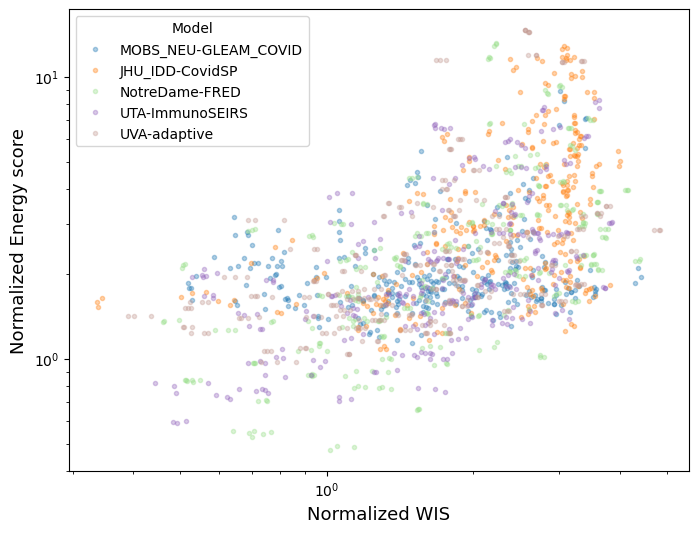

In [420]:
# energy score/wis plot for normalized values

# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17
norm_energyscoresdf = pd.read_pickle('energyscore_norm_hosp_rd17_all.pkl')

wisdfavg = pd.read_pickle(f'megaround_wis_norm_{target}_rd{rd}_scenarios_avg.pkl')
wisdfavg = wisdfavg.rename(columns={'Location':'location_name'})

cmap = plt.get_cmap('tab20', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['MOBS_NEU-GLEAM_COVID', 'JHU_IDD-CovidSP', 'NotreDame-FRED',
       'UTA-ImmunoSEIRS', 'UVA-adaptive']:
    wis = wisdfavg[wisdfavg.Model == model]

    esmod = norm_energyscoresdf[norm_energyscoresdf.Model == model]

    allscores = pd.merge(esmod, wis, how='inner', on=['location_name', 'Label'])


    plt.loglog(allscores.WISavg, allscores.energyscore,'.', alpha=.35,color = colors[i], label = model)
    
    i+=1
    
plt.xlabel('Normalized WIS', fontsize=13)
plt.ylabel('Normalized Energy score', fontsize=13)


plt.legend(title='Model')

#plt.savefig('energyscore_wis_raw.pdf')
plt.show()


# Trajectory ensemble

In [169]:
# lump all trajectories to together - this forms the ensemble model
  
# raw score
modelsall = ['JHU_IDD-CovidSP','NotreDame-FRED', 'UTA-ImmunoSEIRS', 'UVA-adaptive', 'USC-SIkJalpha', 
             'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']
#modelsall = ['USC-SIkJalpha', 'UVA-EpiHiper', 'UNCC-hierbin', 'MOBS_NEU-GLEAM_COVID']

rd =17 
numsamps = 10

start_week = Week(2023, 16)

#loclist = list(predictions.location.unique())
#loclist.remove('US')

energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    #print(model)
    predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')
    predictions['Model'] = model
    predictions['trajectory_id'] = predictions['type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, predictions])
    i += 1
     
loclist = list(predictionsall.location.unique())
loclist.remove('US')
    
#for loc in loclist:
for loc in ['02']:
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

        #scenario = 'B'
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs

        observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])


        predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-04-16') & \
                                      (predictionsall.location == location) & \
                                      (predictionsall.target == 'inc ' + target)  & \
                                      (predictionsall.target_end_date <= observations.date.unique().max()) & \
                                      (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

        a = list(predictionsfilt.trajectory_id.unique())
        samps = random.sample(a, numsamps)

        predictionsfilt = predictionsfilt[predictionsfilt.trajectory_id.isin(samps) ]
        
        for i in [predictionsfilt.type_id.unique()[0]]:
            pfilt = predictionsfilt[predictionsfilt.trajectory_id == i]


        observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                    (observations['date'] <= predictionsfilt.target_end_date.unique().max())]

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)


        check = (observations.date.unique() == predictionsfilt.target_end_date.unique()).all()
        if check == False:
            print('dates do not match')
            print(loc)
            print(i)
            print(list(observations.date))
            print(list(pfilt.target_end_date))


        N = len(predictionsfilt.trajectory_id.unique())
        M = len(observations)

        # first term
             
        observations['target_end_date'] = observations['date']
        pfilt = predictionsfilt.merge(observations, how='left', on=['location', 'target_end_date'])
        pfilt['diff_sq']=(pfilt.value_x - pfilt.value_y)**2

        ES1 = 1/N*sum(np.sqrt(np.array(pfilt.groupby(['trajectory_id']).sum()['diff_sq'])))
        


        # second term
         
        cross = predictionsfilt.merge(predictionsfilt, how='cross')
        crossfilt = cross.loc[(cross['target_end_date_x'] == cross['target_end_date_y']) ]
        
        crossfilt['diff_sq'] = (crossfilt.value_x - crossfilt.value_y)**2
        ES2 = 1/(2*N**2) * sum(np.sqrt(np.array(crossfilt.groupby(['trajectory_id_x', 'trajectory_id_y']).sum()['diff_sq'])))
        
        ES = ES1 - ES2

        #energyscores[loc][scenario] = ES

        if int(loc) <10:
            loc_conv = loc[1]
        else:
            loc_conv = loc  

        newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv, 'energyscore':ES, 
                              'target':target}, index=[0])

        energyscoresdf = pd.concat([energyscoresdf, newrow])
        
energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   

            
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')



In [170]:
energyscoresdf

,Label,location,energyscore,target,abbreviation,location_name,population
0,Scenario A,2,28.908104,hosp,AK,Alaska,731545
1,Scenario B,2,40.614519,hosp,AK,Alaska,731545
2,Scenario C,2,34.040061,hosp,AK,Alaska,731545
3,Scenario D,2,33.526282,hosp,AK,Alaska,731545
4,Scenario E,2,33.510795,hosp,AK,Alaska,731545
5,Scenario F,2,37.868318,hosp,AK,Alaska,731545


In [165]:
list(observations.date)

[Timestamp('2023-04-22 00:00:00'),
 Timestamp('2023-04-29 00:00:00'),
 Timestamp('2023-05-06 00:00:00'),
 Timestamp('2023-05-13 00:00:00'),
 Timestamp('2023-05-20 00:00:00'),
 Timestamp('2023-05-27 00:00:00'),
 Timestamp('2023-06-03 00:00:00'),
 Timestamp('2023-06-10 00:00:00'),
 Timestamp('2023-06-17 00:00:00'),
 Timestamp('2023-06-24 00:00:00'),
 Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-07-08 00:00:00'),
 Timestamp('2023-07-15 00:00:00'),
 Timestamp('2023-07-22 00:00:00'),
 Timestamp('2023-07-29 00:00:00'),
 Timestamp('2023-08-05 00:00:00'),
 Timestamp('2023-08-12 00:00:00'),
 Timestamp('2023-08-19 00:00:00'),
 Timestamp('2023-08-26 00:00:00')]

In [153]:
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                                    (observations['date'] <= predictionsfilt.target_end_date.unique().max())]

#filter location
observations = observations[observations['location'] == location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)



In [159]:
list(observations.date) == list(pfilt.target_end_date.unique())

True

In [158]:
list(pfilt.target_end_date)

[Timestamp('2023-04-22 00:00:00'),
 Timestamp('2023-04-22 00:00:00'),
 Timestamp('2023-04-29 00:00:00'),
 Timestamp('2023-04-29 00:00:00'),
 Timestamp('2023-05-06 00:00:00'),
 Timestamp('2023-05-06 00:00:00'),
 Timestamp('2023-05-13 00:00:00'),
 Timestamp('2023-05-13 00:00:00'),
 Timestamp('2023-05-20 00:00:00'),
 Timestamp('2023-05-20 00:00:00'),
 Timestamp('2023-05-27 00:00:00'),
 Timestamp('2023-05-27 00:00:00'),
 Timestamp('2023-06-03 00:00:00'),
 Timestamp('2023-06-03 00:00:00'),
 Timestamp('2023-06-10 00:00:00'),
 Timestamp('2023-06-10 00:00:00'),
 Timestamp('2023-06-17 00:00:00'),
 Timestamp('2023-06-17 00:00:00'),
 Timestamp('2023-06-24 00:00:00'),
 Timestamp('2023-06-24 00:00:00'),
 Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-07-08 00:00:00'),
 Timestamp('2023-07-08 00:00:00'),
 Timestamp('2023-07-15 00:00:00'),
 Timestamp('2023-07-15 00:00:00'),
 Timestamp('2023-07-22 00:00:00'),
 Timestamp('2023-07-22 00:00:00'),
 Timestamp('2023-07-

In [18]:
energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')


In [23]:
energyscoresdf100 = energyscoresdf

In [91]:
energyscoresdf100[energyscoresdf100.location == '12']

,Label,location,energyscore,target,abbreviation,location_name,population
54,Scenario A,12,3107.183806,hosp,FL,Florida,21477737
55,Scenario B,12,2488.129264,hosp,FL,Florida,21477737
56,Scenario C,12,3219.289242,hosp,FL,Florida,21477737
57,Scenario D,12,2448.530103,hosp,FL,Florida,21477737
58,Scenario E,12,3167.944613,hosp,FL,Florida,21477737
59,Scenario F,12,2420.425134,hosp,FL,Florida,21477737


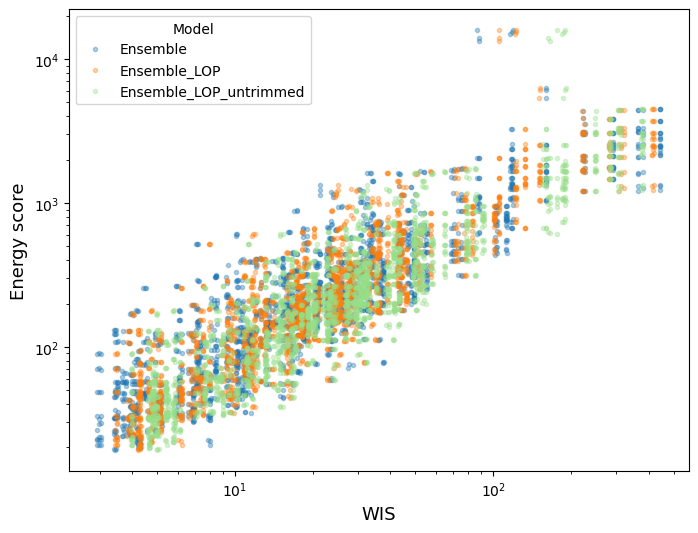

In [22]:
# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17
es = pd.read_pickle('energyscore_raw_hosp_rd17_all.pkl')

wisdf = pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 
wisdf = wisdf.rename(columns={'Location':'location_name'})

cmap = plt.get_cmap('tab20', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    wis = wisdf[wisdf.Model == model]

    esmod = es

    allscores = pd.merge(esmod, wis, how='inner', on=['location_name', 'Label'])


    plt.loglog(allscores.WIS, allscores.energyscore,'.', alpha=.35,color = colors[i], label = model)
    
    i+=1
    
plt.xlabel('SMH Ensemble WIS', fontsize=13)
plt.ylabel('Sampled Trajectory Energy score', fontsize=13)


plt.legend(title='Model')

#plt.savefig('energyscore_wis_raw.pdf')
plt.show()


In [118]:
predictionsall.target_end_date.unique().max()

numpy.datetime64('2028-04-15T00:00:00.000000000')

In [119]:
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])


In [122]:
observations.date.unique().max()

numpy.datetime64('2023-09-01T00:00:00.000000000')

In [125]:
observations[observations.location=='12'].date.max()

Timestamp('2023-09-01 00:00:00')

In [126]:
max_date = pd.to_datetime('2023-09-01')

In [127]:
max_date

Timestamp('2023-09-01 00:00:00')

In [130]:
predictionsfilt.target_end_date.unique().max()

numpy.datetime64('2023-08-26T00:00:00.000000000')

In [141]:
predictionsall[(predictionsall.location == '02')&(predictionsall.trajectory_id == 9.) & \
               (predictionsall.target == 'inc hosp') & (predictionsall.scenario_id == 'F' + '-2023-04-16') &\
               (predictionsall.target_end_date <= observations.date.unique().max())]

,origin_date,scenario_id,target,horizon,location,type_id,value,type,quantile,target_end_date,Model,trajectory_id
4711408,2023-04-16,F-2023-04-16,inc hosp,1.0,02,9.0,9.661771,sample,9.0,2023-04-22,JHU_IDD-CovidSP,9.0
5023408,2023-04-16,F-2023-04-16,inc hosp,2.0,02,9.0,12.188959,sample,9.0,2023-04-29,JHU_IDD-CovidSP,9.0
5335408,2023-04-16,F-2023-04-16,inc hosp,3.0,02,9.0,15.315428,sample,9.0,2023-05-06,JHU_IDD-CovidSP,9.0
5647408,2023-04-16,F-2023-04-16,inc hosp,4.0,02,9.0,18.001068,sample,9.0,2023-05-13,JHU_IDD-CovidSP,9.0
5959408,2023-04-16,F-2023-04-16,inc hosp,5.0,02,9.0,18.348098,sample,9.0,2023-05-20,JHU_IDD-CovidSP,9.0
6271408,2023-04-16,F-2023-04-16,inc hosp,6.0,02,9.0,18.992562,sample,9.0,2023-05-27,JHU_IDD-CovidSP,9.0
6583408,2023-04-16,F-2023-04-16,inc hosp,7.0,02,9.0,19.712590,sample,9.0,2023-06-03,JHU_IDD-CovidSP,9.0
6895408,2023-04-16,F-2023-04-16,inc hosp,8.0,02,9.0,21.687498,sample,9.0,2023-06-10,JHU_IDD-CovidSP,9.0
7207408,2023-04-16,F-2023-04-16,inc hosp,9.0,02,9.0,30.439872,sample,9.0,2023-06-17,JHU_IDD-CovidSP,9.0
7519408,2023-04-16,F-2023-04-16,inc hosp,10.0,02,9.0,43.258193,sample,9.0,2023-06-24,JHU_IDD-CovidSP,9.0


In [283]:
samplescoresall = pd.DataFrame()
for i in range(1,21):
    df = pd.read_pickle(f'./dat/samplescores/energyscore_ensemble_sample_rd17_hosp_it{i}.pkl')
    samplescoresall = pd.concat([samplescoresall, df])

In [284]:
samplescoresall

,Label,location,energyscore,target,abbreviation,location_name,population
0,Scenario A,2,28.228696,hosp,AK,Alaska,731545
1,Scenario B,2,27.012980,hosp,AK,Alaska,731545
2,Scenario C,2,30.453522,hosp,AK,Alaska,731545
3,Scenario D,2,27.888366,hosp,AK,Alaska,731545
4,Scenario E,2,29.608747,hosp,AK,Alaska,731545
...,...,...,...,...,...,...,...
301,Scenario B,56,34.373852,hosp,WY,Wyoming,578759
302,Scenario C,56,39.475786,hosp,WY,Wyoming,578759
303,Scenario D,56,35.625836,hosp,WY,Wyoming,578759
304,Scenario E,56,37.541036,hosp,WY,Wyoming,578759


<Axes: xlabel='energyscore'>

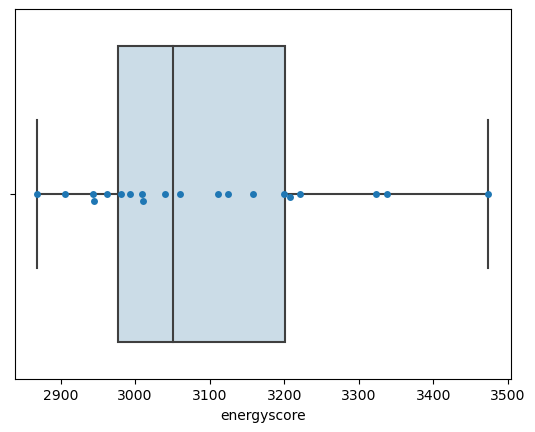

In [285]:
ab = samplescoresall[(samplescoresall.location == '12') & (samplescoresall.Label == 'Scenario A')]


fig, ax = plt.subplots(1,1)
sns.boxplot(x='energyscore',  data=ab)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .25))


sns.swarmplot(x='energyscore', data=ab, orient='h')

In [286]:
sampleavg = samplescoresall.groupby(['Label', 'location']).mean().reset_index()
sampleavg = sampleavg.merge(locations, on='location', how='left')

In [396]:
sampleavg

,Label,location,energyscore,population_x,abbreviation,location_name,population_y,target
0,Scenario A,1,351.200253,4903185.0,AL,Alabama,4903185,hosp
1,Scenario A,10,41.089989,973764.0,DE,Delaware,973764,hosp
2,Scenario A,11,49.980725,705749.0,DC,District of Columbia,705749,hosp
3,Scenario A,12,3093.866327,21477737.0,FL,Florida,21477737,hosp
4,Scenario A,13,1054.656951,10617423.0,GA,Georgia,10617423,hosp
...,...,...,...,...,...,...,...,...
301,Scenario F,55,203.563767,5822434.0,WI,Wisconsin,5822434,hosp
302,Scenario F,56,34.888892,578759.0,WY,Wyoming,578759,hosp
303,Scenario F,6,1950.014018,39512223.0,CA,California,39512223,hosp
304,Scenario F,8,173.354138,5758736.0,CO,Colorado,5758736,hosp


In [288]:
wisdf = pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 

wisdf = wisdf.rename(columns={'Location':'location_name'})

wisdf_ens = wisdf[wisdf.Model.isin(['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed'])]

In [289]:
allsamplescores = pd.merge(sampleavg, wisdf_ens, how='inner', on=['location_name', 'Label'])

allsamplescores

,Label,location,energyscore,population_x,abbreviation,location_name,population_y,Model,WIS,Target
0,Scenario A,1,351.200253,4903185.0,AL,Alabama,4903185,Ensemble_LOP,29.192169,hosp
1,Scenario A,1,351.200253,4903185.0,AL,Alabama,4903185,Ensemble_LOP_untrimmed,29.319911,hosp
2,Scenario A,1,351.200253,4903185.0,AL,Alabama,4903185,Ensemble,26.717516,hosp
3,Scenario A,10,41.089989,973764.0,DE,Delaware,973764,Ensemble_LOP,6.976096,hosp
4,Scenario A,10,41.089989,973764.0,DE,Delaware,973764,Ensemble_LOP_untrimmed,7.301204,hosp
...,...,...,...,...,...,...,...,...,...,...
913,Scenario F,8,173.354138,5758736.0,CO,Colorado,5758736,Ensemble_LOP_untrimmed,26.803799,hosp
914,Scenario F,8,173.354138,5758736.0,CO,Colorado,5758736,Ensemble,19.086023,hosp
915,Scenario F,9,136.396038,3565287.0,CT,Connecticut,3565287,Ensemble_LOP,17.451829,hosp
916,Scenario F,9,136.396038,3565287.0,CT,Connecticut,3565287,Ensemble_LOP_untrimmed,20.452621,hosp


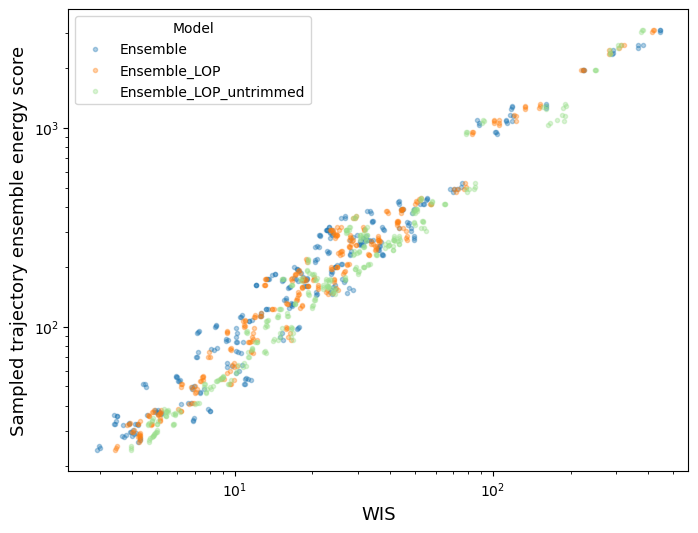

In [290]:
# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17

cmap = plt.get_cmap('tab20', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    df = allsamplescores[allsamplescores.Model == model]
    plt.loglog(df.WIS, df.energyscore,'.', alpha=.35,color = colors[i], label = model)
    
    i+=1
    
plt.xlabel('WIS', fontsize=13)
plt.ylabel('Sampled trajectory ensemble energy score', fontsize=13)


plt.legend(title='Model')

#plt.savefig('energyscore_sample_wis_ensemble.pdf')
plt.show()


In [446]:
# unsampled
df = pd.read_pickle(f'./dat/energyscore_ensemble_nosample_rd17_hosp.pkl')
dfens = df.groupby(['Label', 'location']).mean().reset_index()
dfens = dfens.merge(locations, on='location', how='left')

wisdf = pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 
wisdf = wisdf.rename(columns={'Location':'location_name'})
wisdf_ens = wisdf[wisdf.Model.isin(['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed'])]

allscores = pd.merge(dfens, wisdf_ens, how='inner', on=['location_name', 'Label'])


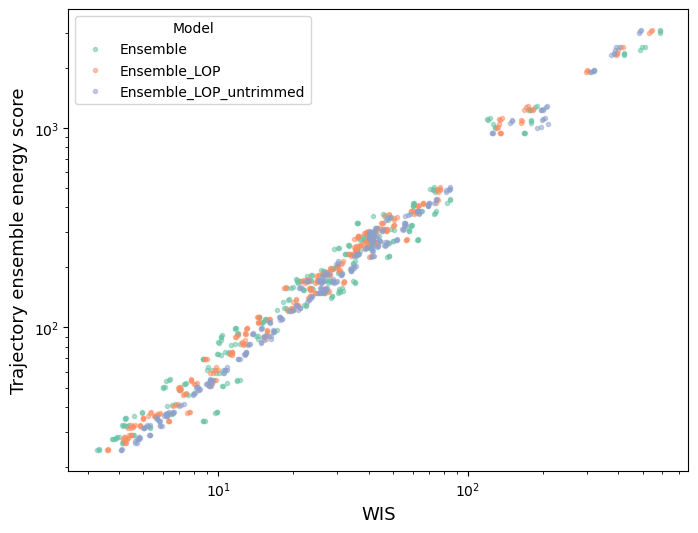

In [503]:
# energy score plot
fig, axes = plt.subplots(figsize=(8, 6))
rd = 17

cmap = plt.get_cmap('Set2', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    df = allscores[allscores.Model == model]
    plt.loglog(df.WIS, df.energyscore,'.', alpha=.5,color = colors[i], label = model)
    
    i+=1
    
plt.xlabel('WIS', fontsize=13)
plt.ylabel('Trajectory ensemble energy score', fontsize=13)


plt.legend(title='Model')

plt.savefig('energyscore_wis_ensemble.pdf')
plt.show()


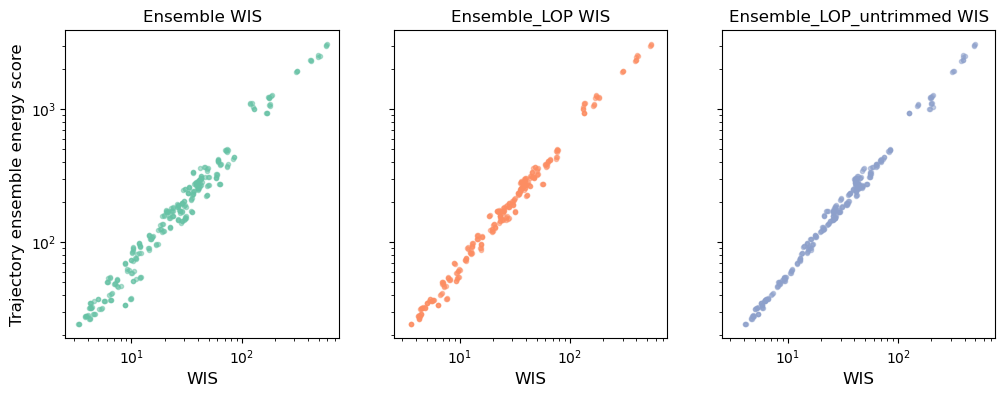

In [448]:
# energy score plot
fig, axes = plt.subplots(1,3,figsize=(12, 4), sharex=True, sharey=True)
rd = 17

cmap = plt.get_cmap('Set2', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

i=0
for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    plt.subplot(1,3,i+1)
    df = allscores[allscores.Model == model]
    plt.loglog(df.WIS, df.energyscore,'.', alpha=.5,color = colors[i], label = model)
    
    i+=1
    
    plt.xlabel('WIS', fontsize=12)
    
    if i == 1:
        plt.ylabel('Trajectory ensemble energy score', fontsize=12)


    plt.title(model + ' WIS')

plt.savefig('energyscore_wis_ensemble_disagg.pdf')
plt.show()


In [391]:
# standardized rank WIS

rds = [ 17]
dfrankall = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank','Target','Round'])
for rd in rds:
    dfa =  pd.read_pickle(f'megaround_wis_{target}_rd{rd}_scenarios.pkl') 
    
    dfrank = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank', 'Target','Round'])

    states = list(dfa.Location.unique())

    for state in states:
        for scenario in dfa.Label.unique():
            filt = dfa[(dfa['Location']==state) & (dfa.Label == scenario)]
            filt = filt.sort_values('WIS')

            rank = list(filt.Model)
            for model in rank:
                rankval = 1 - rank.index(model)/(len(rank)-1)

                new_row = {'Model':model, 'Location': state, 'Standard_Rank': rankval, 'Target':target, 'Round':rd, 
                          'Label':scenario}

                dfrank = dfrank.append(new_row, ignore_index=True)

    dfrankall = pd.concat([dfrankall, dfrank])
dfrankallwis = dfrankall.reset_index()


#dfrankallwis['ModelID'] = dfrankallwis['Model'].map(modelmap)





In [392]:
dfrankallwis = dfrankallwis[dfrankallwis.Label != 'Median aggregate']

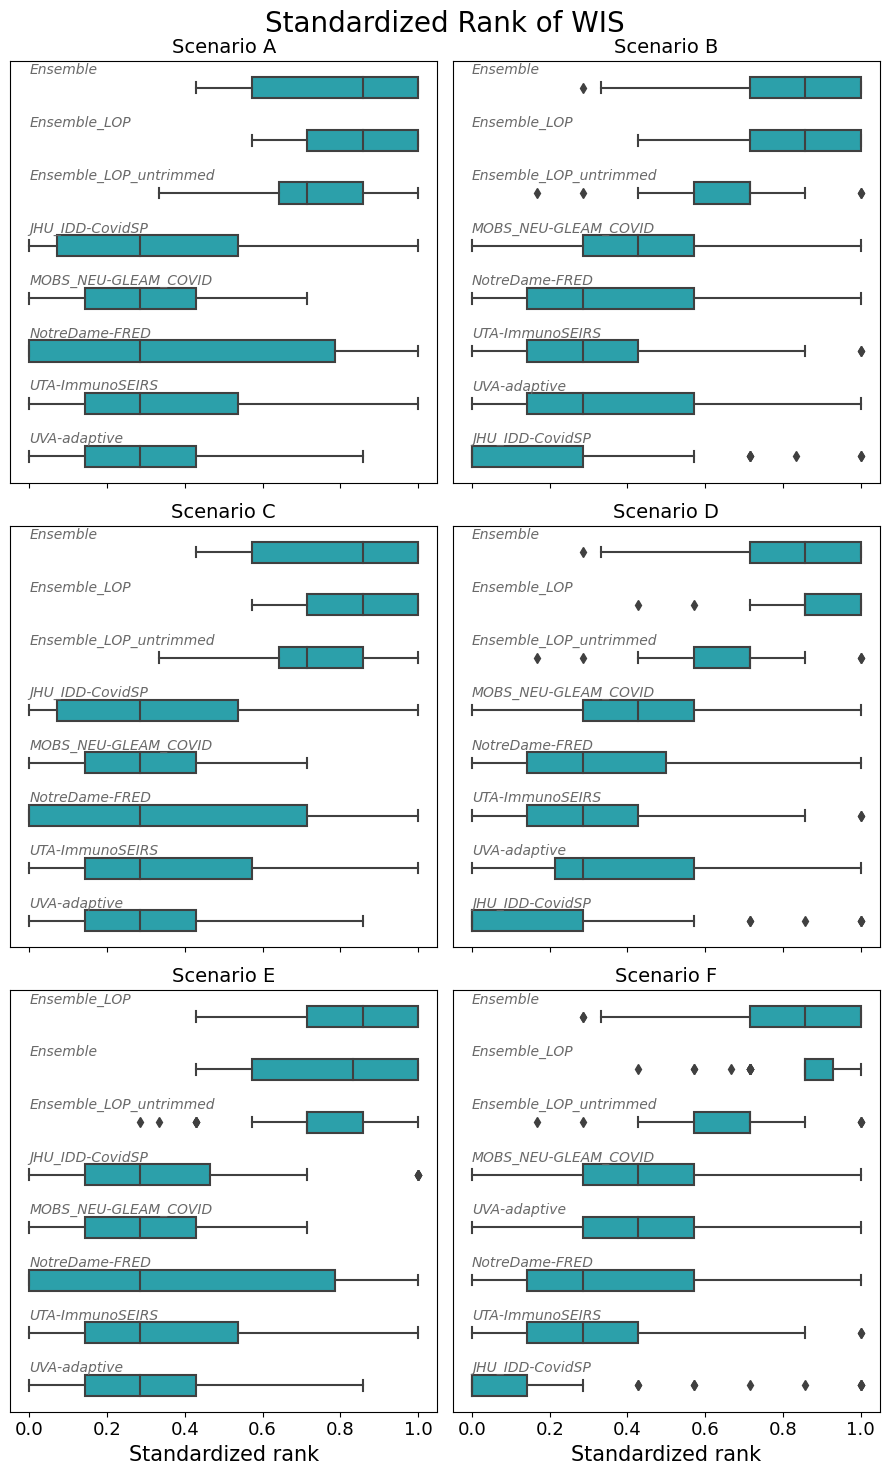

In [394]:
plt.subplots(3,2,figsize=(9,15), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1
for scenario in dfrankallwis.Label.unique():
    plt.subplot(3,2,i)
    
    rankinfo = dfrankallwis[dfrankallwis.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    g = sns.boxplot(x='Standard_Rank', y='Model', data=rankinfo, order = my_order, color = '#17B1BF', width=0.4)
    
    g.set(yticklabels=[])
    g.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        g.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('Standardized rank', fontsize=15)
    else:
        g.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.suptitle('Standardized Rank of WIS', fontsize=20)
plt.tight_layout()
plt.savefig('standardrank_WIS.pdf')
plt.show()


In [438]:
es_models = pd.read_pickle('energyscore_raw_hosp_rd17_models.pkl')

In [439]:
dfens['target'] = 'hosp'
dfens['Model'] = 'Trajectory Ensemble'
es_all = pd.concat([es_models, dfens])

In [440]:
# standardized rank energy score

rds = [ 17]
dfrankall = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank','Target','Round'])
for rd in rds:
    dfa =  es_all.copy()
    
    dfrank = pd.DataFrame(columns=['Model', 'Location', 'Standard_Rank', 'Target','Round'])

    states = list(dfa.location_name.unique())

    for state in states:
        for scenario in dfa.Label.unique():
            filt = dfa[(dfa['location_name']==state) & (dfa.Label == scenario)]
            filt = filt.sort_values('energyscore')

            rank = list(filt.Model)
            for model in rank:
                rankval = 1 - rank.index(model)/(len(rank)-1)

                new_row = {'Model':model, 'Location': state, 'Standard_Rank': rankval, 'Target':target, 'Round':rd, 
                          'Label':scenario}

                dfrank = dfrank.append(new_row, ignore_index=True)

    dfrankall = pd.concat([dfrankall, dfrank])
dfrankallenergyscore = dfrankall.reset_index()


#dfrankallwis['ModelID'] = dfrankallwis['Model'].map(modelmap)





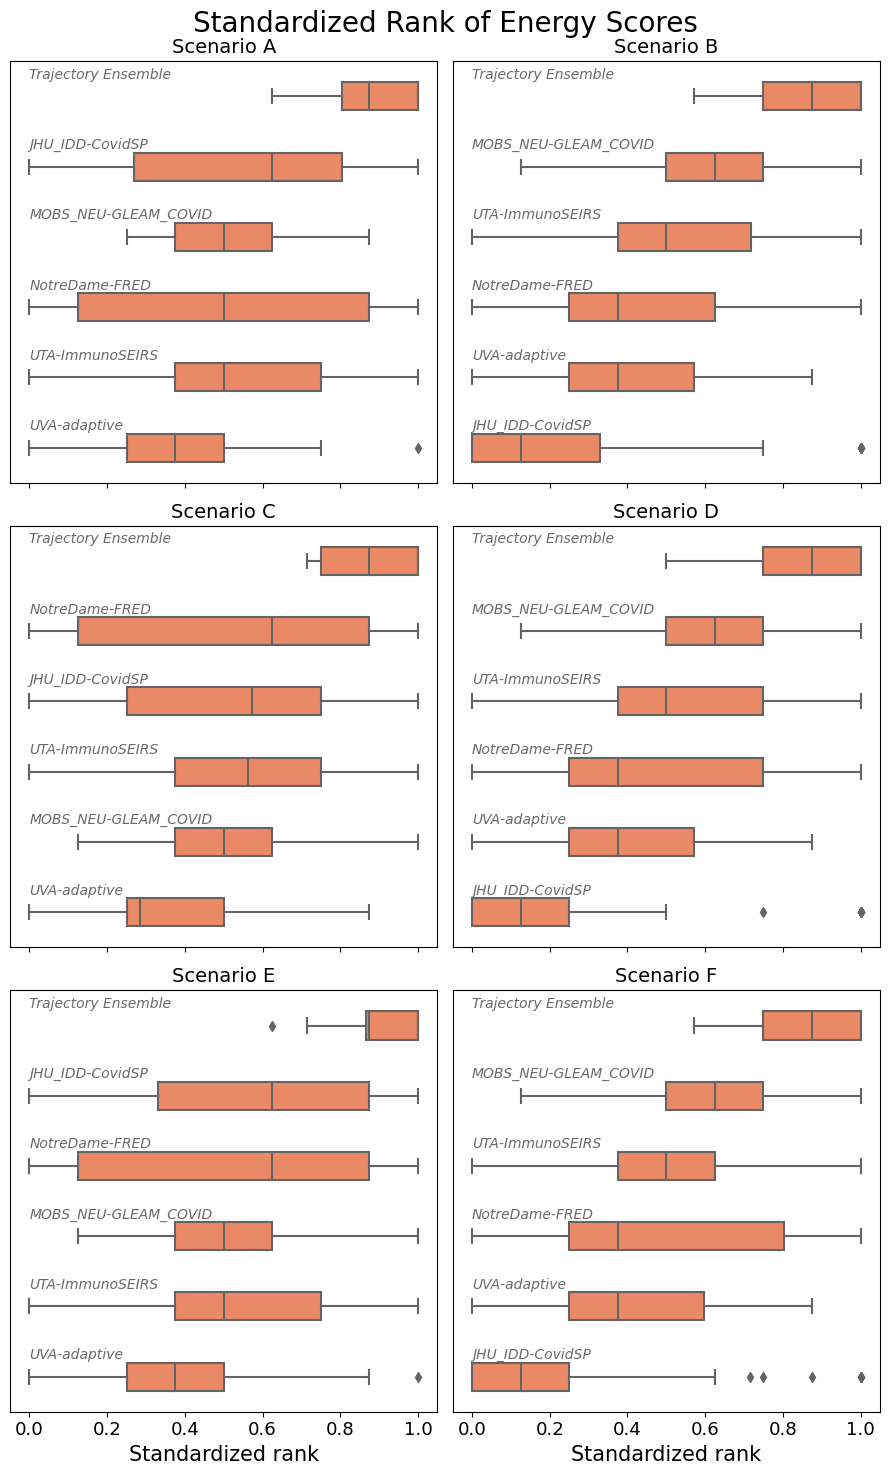

In [442]:
plt.subplots(3,2,figsize=(9,15), sharex=True)
#plt.subplots_adjust(hspace=4)
i=1

dfrankallenergyscore = dfrankallenergyscore[(dfrankallenergyscore.Model != 'UNCC-hierbin') &\
                                            (dfrankallenergyscore.Model != 'UVA-EpiHiper') &\
                                            (dfrankallenergyscore.Model != 'USC-SIkJalpha')]
for scenario in dfrankallenergyscore.Label.unique():
    plt.subplot(3,2,i)
    
    rankinfo = dfrankallenergyscore[dfrankallenergyscore.Label == scenario]
    
    
    my_order = rankinfo.groupby(by=["Model"])["Standard_Rank"].median().sort_values(ascending=False).index
    
    ges = sns.boxplot(x='Standard_Rank', y='Model', data=rankinfo, order = my_order, color = 'coral', width=0.4)
    
    ges.set(yticklabels=[])
    ges.set(yticks=[])
        
    if i in [1, 3,5]:
        plt.ylabel('', fontsize=15)
    else:
        ges.set(ylabel=None)    
        
    if i in [5,6]:
        plt.xlabel('Standardized rank', fontsize=15)
    else:
        ges.set(xlabel=None)

    i+=1 
    plt.title(scenario, fontsize=14)
    
    a = 0
    for mod in list(my_order):
        plt.text(0,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1
    
    plt.xticks(fontsize=13)
plt.suptitle('Standardized Rank of Energy Scores', fontsize=20)
plt.tight_layout()
plt.savefig('standardrank_energyscore.pdf')
plt.show()


In [389]:
fulles = pd.read_csv('test_ES_team_locations_0422-0826_Scenario-A.csv')
fulles = fulles.rename(columns={'ES':'energyscorefull', 'state':'abbreviation', 'team':'Model'})
fulles

,scenario_id,location,Model,abbreviation,part1_sum,num_runs,part2_sum,energyscorefull
0,A-2023-04-16,02,USC-SIkJalpha,AK,6510.622633,90,2.523193e+05,56.764985
1,A-2023-04-16,01,USC-SIkJalpha,AL,38677.319401,90,4.942987e+05,399.235726
2,A-2023-04-16,05,USC-SIkJalpha,AR,24289.367408,90,1.731104e+05,259.196033
3,A-2023-04-16,04,USC-SIkJalpha,AZ,22396.114934,90,5.153288e+05,217.035300
4,A-2023-04-16,06,USC-SIkJalpha,CA,327805.131515,90,2.229602e+07,2265.981988
...,...,...,...,...,...,...,...,...
409,A-2023-04-16,56,UVA-adaptive,WY,6751.059386,100,8.800477e+04,63.110356
410,A-2023-04-16,56,JHU_IDD-CovidSP,WY,7047.671756,100,9.168785e+05,24.632792
411,A-2023-04-16,56,UTA-ImmunoSEIRS,WY,5512.149523,100,2.693393e+04,53.774799
412,A-2023-04-16,56,NotreDame-FRED,WY,5086.427573,100,3.614560e+05,32.791475


In [390]:
fulles[(fulles.Model == 'MOBS_NEU-GLEAM_COVID') & (fulles.location == '12')]

,scenario_id,location,Model,abbreviation,part1_sum,num_runs,part2_sum,energyscorefull
114,A-2023-04-16,12,MOBS_NEU-GLEAM_COVID,FL,472880.236344,100,2.405203e+07,3526.201073


In [344]:
es_models = pd.read_pickle('energyscore_raw_hosp_rd17_all.pkl')
es_modelsA = es_models[es_models.Label == 'Scenario A']

In [345]:
escomp = fulles.merge(es_modelsA, on=['Model', 'location'])

In [346]:
escomp

,scenario_id,location,Model,abbreviation_x,part1_sum,num_runs,part2_sum,energyscorefull,Label,energyscore,target,abbreviation_y,location_name,population
0,A-2023-04-16,11,USC-SIkJalpha,DC,14852.789977,90,7.079571e+05,121.329943,Scenario A,121.329943,hosp,DC,District of Columbia,705749
1,A-2023-04-16,10,USC-SIkJalpha,DE,4380.799873,90,1.451809e+04,47.779376,Scenario A,47.779376,hosp,DE,Delaware,973764
2,A-2023-04-16,12,USC-SIkJalpha,FL,291521.649129,90,1.197291e+07,2500.061133,Scenario A,2495.700603,hosp,FL,Florida,21477737
3,A-2023-04-16,13,USC-SIkJalpha,GA,77968.764653,90,1.761865e+05,855.443895,Scenario A,855.443895,hosp,GA,Georgia,10617423
4,A-2023-04-16,15,USC-SIkJalpha,HI,22871.937092,90,7.838643e+05,205.745947,Scenario A,205.745947,hosp,HI,Hawaii,1415872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,A-2023-04-16,56,UNCC-hierbin,WY,3194.273245,100,2.150514e+04,30.867476,Scenario A,30.867476,hosp,WY,Wyoming,578759
345,A-2023-04-16,56,UTA-ImmunoSEIRS,WY,4338.112612,100,2.450981e+04,42.155636,Scenario A,42.155636,hosp,WY,Wyoming,578759
346,A-2023-04-16,56,NotreDame-FRED,WY,5013.790553,100,3.431185e+05,32.981983,Scenario A,32.981983,hosp,WY,Wyoming,578759
347,A-2023-04-16,56,UVA-EpiHiper,WY,5708.453323,100,1.363103e+05,50.269020,Scenario A,50.269020,hosp,WY,Wyoming,578759


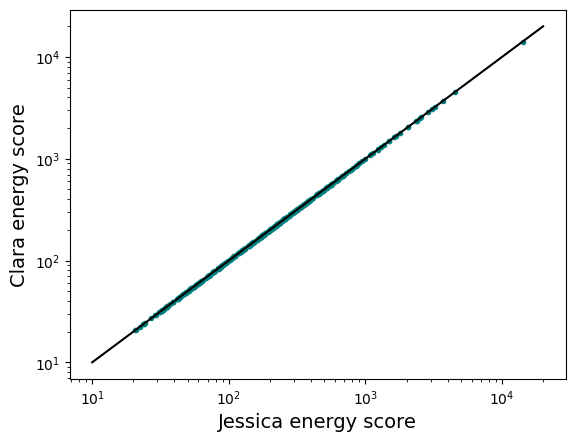

In [347]:
plt.loglog(escomp.energyscorefull, escomp.energyscore, '.', color = 'teal')
plt.loglog(np.linspace(10,20000,100), np.linspace(10,20000,100), color='k')

plt.xlabel('Jessica energy score', fontsize=14)
plt.ylabel('Clara energy score', fontsize=14)

plt.savefig('compareenergyscores.pdf')

In [320]:
# make some sort of trajectory ensemble plot

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    #print(model)
    predictions = pd.read_parquet(f'./dat/{model}_rd{rd}_trajectories.pq')
    predictions['Model'] = model
    predictions['trajectory_id'] = predictions['type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, predictions])
    i += 1


predictionsall



,origin_date,scenario_id,target,horizon,location,type_id,value,type,quantile,target_end_date,Model,trajectory_id
0,2023-04-16,D-2023-04-16,inc death,38.0,02,1.0,2.491371,sample,1.0,2024-01-06,JHU_IDD-CovidSP,1.0
1,2023-04-16,D-2023-04-16,inc death,38.0,02,2.0,9.009723,sample,2.0,2024-01-06,JHU_IDD-CovidSP,2.0
2,2023-04-16,D-2023-04-16,inc death,38.0,02,3.0,1.694314,sample,3.0,2024-01-06,JHU_IDD-CovidSP,3.0
3,2023-04-16,D-2023-04-16,inc death,38.0,02,4.0,7.079947,sample,4.0,2024-01-06,JHU_IDD-CovidSP,4.0
4,2023-04-16,D-2023-04-16,inc death,38.0,02,5.0,7.758006,sample,5.0,2024-01-06,JHU_IDD-CovidSP,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6551995,2023-04-16,F-2023-04-16,inc death,105.0,US,96.0,5890.066000,sample,96.0,2025-04-19,MOBS_NEU-GLEAM_COVID,796.0
6551996,2023-04-16,F-2023-04-16,inc death,105.0,US,97.0,5587.108000,sample,97.0,2025-04-19,MOBS_NEU-GLEAM_COVID,797.0
6551997,2023-04-16,F-2023-04-16,inc death,105.0,US,98.0,5171.830000,sample,98.0,2025-04-19,MOBS_NEU-GLEAM_COVID,798.0
6551998,2023-04-16,F-2023-04-16,inc death,105.0,US,99.0,4804.643000,sample,99.0,2025-04-19,MOBS_NEU-GLEAM_COVID,799.0


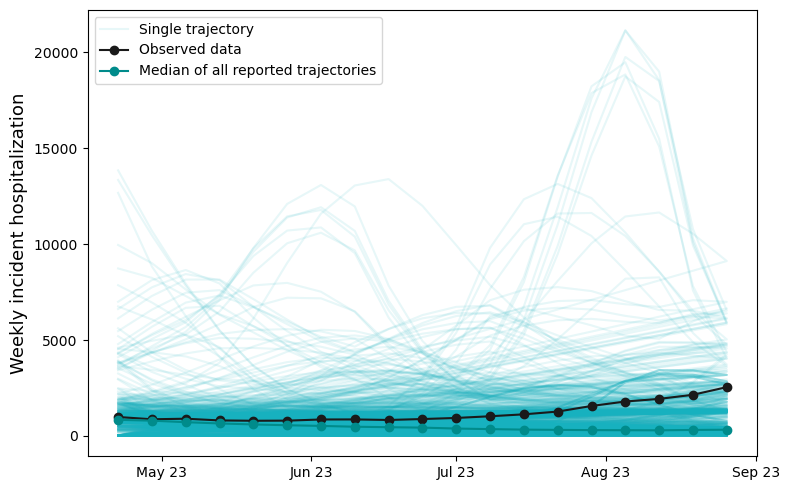

In [334]:
# plot trajectories and observations for scenario A of megaround and for Florida

fig, axes = plt.subplots(figsize=(8, 5))
start_week = Week(2023, 16)

scenario = 'B'
location = '12'
target = 'hosp'
incidence = True

if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-04-16') & \
                              (predictionsall.location == location) & \
                              (predictionsall.target == 'inc ' + target)  & \
                              (predictionsall.target_end_date <= observations.date.unique().max()) & \
                              (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

for i in predictionsfilt.type_id.unique():
    pfilt = predictionsfilt[predictionsfilt.type_id == i]
    
    if i != predictionsfilt.type_id.unique()[-1]:
        plt.plot(pfilt.target_end_date, pfilt['value'], color = '#17B1BF', alpha = .1)
    else:
        plt.plot(pfilt.target_end_date, pfilt['value'], color = '#17B1BF', alpha = .1, label = 'Single trajectory')
    

    
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                            (observations['date'] <= pfilt.target_end_date.unique().max())]

#filter location
observations = observations[observations['location'] == location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

plt.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Observed data')
    

predfiltmed = predictionsfilt.groupby(['horizon']).median().reset_index()

plt.plot(pfilt.target_end_date.unique(), predfiltmed['value'],'-o', color = 'darkcyan',
         label = 'Median of all reported trajectories')

plt.ylabel('Weekly incident ' + target_obs, fontsize=13)

    
set_date_axis_fmt(axes)

    
plt.legend()
plt.tight_layout()
plt.show()

In [337]:
a = predictionsfilt.merge(predictionsfilt, on = ['scenario_id','location','target_end_date'], suffixes = ["_i","_j"])

In [341]:
a = a.drop(columns = ['target_i', 'origin_date_j', 'target_j', 'type_j'])

In [342]:
a[a.Model_i == 'JHU_IDD-CovidSP']

,origin_date_i,scenario_id,horizon_i,location,type_id_i,value_i,type_i,quantile_i,target_end_date,Model_i,trajectory_id_i,horizon_j,type_id_j,value_j,quantile_j,Model_j,trajectory_id_j
0,2023-04-16,B-2023-04-16,1.0,12,1.0,776.363242,sample,1.0,2023-04-22,JHU_IDD-CovidSP,1.0,1.0,1.0,776.363242,1.0,JHU_IDD-CovidSP,1.0
1,2023-04-16,B-2023-04-16,1.0,12,1.0,776.363242,sample,1.0,2023-04-22,JHU_IDD-CovidSP,1.0,1.0,2.0,297.077182,2.0,JHU_IDD-CovidSP,2.0
2,2023-04-16,B-2023-04-16,1.0,12,1.0,776.363242,sample,1.0,2023-04-22,JHU_IDD-CovidSP,1.0,1.0,3.0,4260.431124,3.0,JHU_IDD-CovidSP,3.0
3,2023-04-16,B-2023-04-16,1.0,12,1.0,776.363242,sample,1.0,2023-04-22,JHU_IDD-CovidSP,1.0,1.0,4.0,4336.516215,4.0,JHU_IDD-CovidSP,4.0
4,2023-04-16,B-2023-04-16,1.0,12,1.0,776.363242,sample,1.0,2023-04-22,JHU_IDD-CovidSP,1.0,1.0,5.0,309.423466,5.0,JHU_IDD-CovidSP,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11312795,2023-04-16,B-2023-04-16,19.0,12,100.0,1585.109222,sample,100.0,2023-08-26,JHU_IDD-CovidSP,100.0,19.0,96.0,483.414000,96.0,MOBS_NEU-GLEAM_COVID,796.0
11312796,2023-04-16,B-2023-04-16,19.0,12,100.0,1585.109222,sample,100.0,2023-08-26,JHU_IDD-CovidSP,100.0,19.0,97.0,1750.786000,97.0,MOBS_NEU-GLEAM_COVID,797.0
11312797,2023-04-16,B-2023-04-16,19.0,12,100.0,1585.109222,sample,100.0,2023-08-26,JHU_IDD-CovidSP,100.0,19.0,98.0,1004.450000,98.0,MOBS_NEU-GLEAM_COVID,798.0
11312798,2023-04-16,B-2023-04-16,19.0,12,100.0,1585.109222,sample,100.0,2023-08-26,JHU_IDD-CovidSP,100.0,19.0,99.0,1028.148000,99.0,MOBS_NEU-GLEAM_COVID,799.0


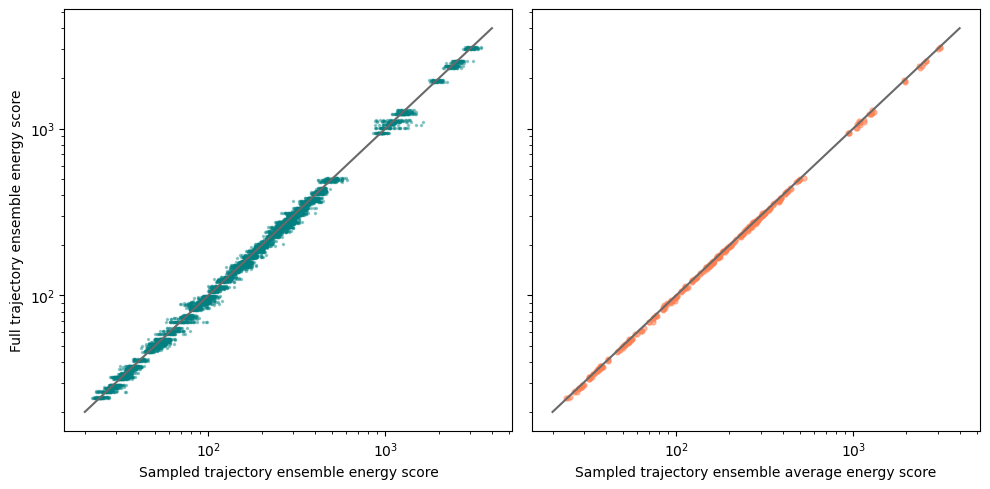

In [434]:
# compare sampled data and full trajectory ensemble
plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

plt.subplot(1,2,1)
fullens_all = samplescoresall.merge(dfens, how='left', on = ['Label', 'location'])


plt.loglog(fullens_all.energyscore_x, fullens_all.energyscore_y, '.', color = 'teal', markersize=3, alpha=.35)


plt.loglog(np.logspace(np.log10(20),np.log10(4000),100), np.logspace(np.log10(20),np.log10(4000),100), 'dimgray')

plt.xlabel('Sampled trajectory ensemble energy score')
plt.ylabel('Full trajectory ensemble energy score')


plt.subplot(1,2,2)
fullens_all = sampleavg.merge(dfens, how='left', on = ['Label', 'location'])


plt.loglog(fullens_all.energyscore_x, fullens_all.energyscore_y, '.', color = 'coral', markersize=7, alpha=.5)


plt.loglog(np.logspace(np.log10(20),np.log10(4000),100), np.logspace(np.log10(20),np.log10(4000),100), 'dimgray')

plt.xlabel('Sampled trajectory ensemble average energy score')
#plt.ylabel('Full trajectory ensemble energy score')


plt.tight_layout()

plt.savefig('samplesvsens.pdf')

plt.show()

In [464]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

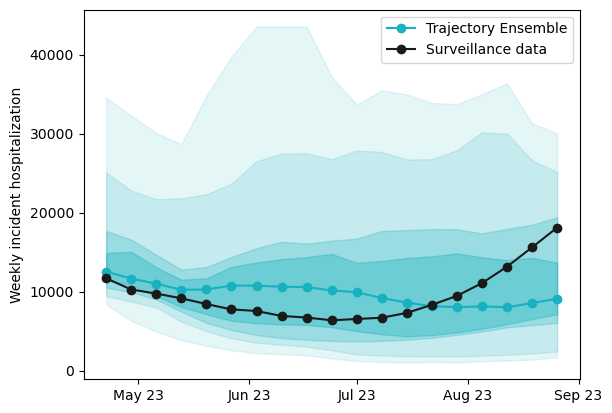

In [474]:
fig, axes = plt.subplots(1,1)

start_week = Week(2023, 16)

scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-04-16') & \
                              (predictionsall.location == location) & \
                              (predictionsall.target == 'inc ' + target)  & \
                              (predictionsall.target_end_date <= observations.date.unique().max()) & \
                              (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(predictionsfilt.groupby('horizon')['value'].quantile(q[0]))
    qlow = list(predictionsfilt.groupby('horizon')['value'].quantile(q[1]))
    
    plt.fill_between(predictionsfilt.target_end_date.unique(),qupp,qlow, color='#17B1BF', alpha=alpha)
    
qmed = list(predictionsfilt.groupby('horizon')['value'].quantile(.5))

plt.plot(predictionsfilt.target_end_date.unique(),qmed,'-o', color='#17B1BF', alpha=1,
                               label=fr"Trajectory Ensemble")
    

observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                            (observations['date'] <= pd.to_datetime('2023-08-26'))]


    
#filter location
observations = observations[observations['location'] == location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
    
    
    
set_date_axis_fmt(axes)

#set y axis 
axes.set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization")
    
    
plt.legend()



plt.show()

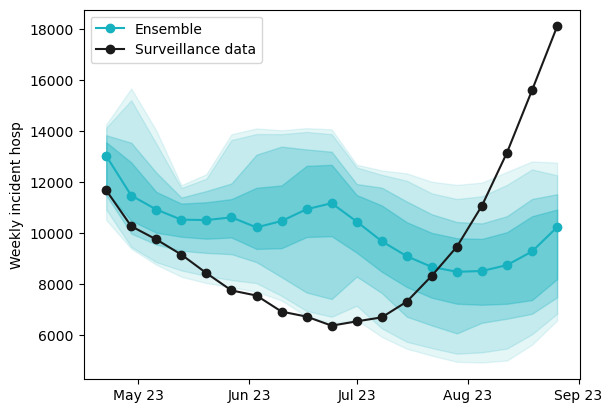

In [491]:
fig, axes = plt.subplots(1,1)

#model = "Ensemble"
model = 'Ensemble'
rd=17
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')


map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

predictions["scenario_letter"] = predictions.scenario_id.str[0]
predictions.drop(predictions[predictions.type == 'point'].index, inplace=True)

incidence = True
target = 'hosp'
target_location = 'US'

if target == 'hosp':
    target_obs = 'hospitalization'
elif target == 'death':
    target_obs = 'death_new'
else:
    target_obs = target
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime('2023-08-26'))]


    
#filter location
observations = observations[observations['location'] == target_location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

target_prediction_list = [f"{'inc' if incidence else 'cum'} {target}" ]

predictions = predictions[predictions.location == target_location]
predictions = predictions[(predictions['target'].isin(target_prediction_list))]



predictions = predictions[(predictions.scenario_letter == scenario) & \
                          (predictions.target_end_date <= pd.to_datetime('2023-08-26'))]

t = predictions.target_end_date.unique()
              
intervals = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
#intervals = [(.35, .65)]
for interval in intervals:
    q_low,q_upp = interval
    interval_range = q_upp - q_low
    alpha = map_alpha(interval_range)
    pred_low = list(predictions.groupby('horizon')['value'].quantile(q_low))
    pred_upp = list(predictions.groupby('horizon')['value'].quantile(q_upp))
    axes.fill_between(t,pred_upp,pred_low, color='#17B1BF', alpha=alpha)

#point estimate
pred_point = list(predictions.groupby('horizon')['value'].quantile(.5))
if len(pred_point) > 0:
    axes.plot(t,pred_point,'-o',color='#17B1BF', label = model)

#plot surveillance
axes.plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

#set x axis
set_date_axis_fmt(axes)


#set y axis 
axes.set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")

plt.legend()

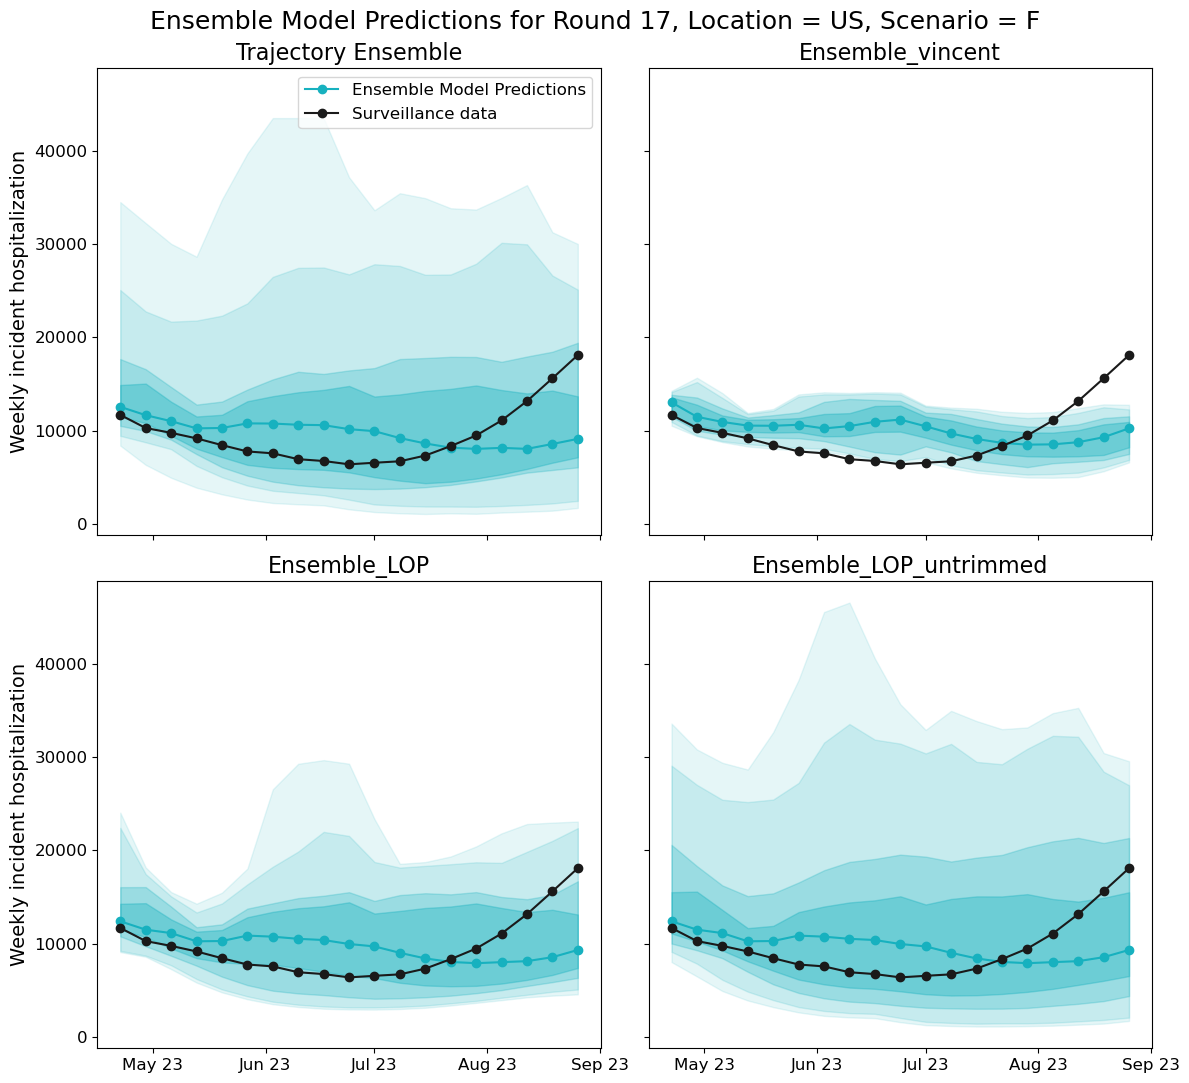

In [502]:
fig, axes = plt.subplots(2,2,figsize=(12,11), sharey=True, sharex = True)

start_week = Week(2023, 16)

scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


plt.subplot(2,2,1)

if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    
observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-04-16') & \
                              (predictionsall.location == location) & \
                              (predictionsall.target == 'inc ' + target)  & \
                              (predictionsall.target_end_date <= observations.date.unique().max()) & \
                              (predictionsall.target_end_date >= pd.to_datetime(start_week.startdate()))]

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(predictionsfilt.groupby('horizon')['value'].quantile(q[0]))
    qlow = list(predictionsfilt.groupby('horizon')['value'].quantile(q[1]))
    
    plt.fill_between(predictionsfilt.target_end_date.unique(),qupp,qlow, color='#17B1BF', alpha=alpha)
    
qmed = list(predictionsfilt.groupby('horizon')['value'].quantile(.5))

plt.plot(predictionsfilt.target_end_date.unique(),qmed,'-o', color='#17B1BF', alpha=1,
                               label=fr"Ensemble Model Predictions")
    

observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & \
                            (observations['date'] <= pd.to_datetime('2023-08-26'))]


    
#filter location
observations = observations[observations['location'] == location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


axes[0][0].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
    
    
    
set_date_axis_fmt(axes[0][0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#set y axis 
plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization", fontsize=14)

plt.title('Trajectory Ensemble', fontsize=16)
    
plt.legend(fontsize=12)


i=2 

for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
    plt.subplot(2,2,i)
    
    if i == 2:
        a = 0
        b = 1
    elif i ==3:
        a = 1
        b = 0
    else:
        a=1
        b=1
    
    rd=17
    predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')


    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

    predictions["scenario_letter"] = predictions.scenario_id.str[0]
    predictions.drop(predictions[predictions.type == 'point'].index, inplace=True)

    incidence = True
    target = 'hosp'
    target_location = 'US'

    if target == 'hosp':
        target_obs = 'hospitalization'
    elif target == 'death':
        target_obs = 'death_new'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                                (observations['date'] <= pd.to_datetime('2023-08-26'))]



    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    target_prediction_list = [f"{'inc' if incidence else 'cum'} {target}" ]

    predictions = predictions[predictions.location == target_location]
    predictions = predictions[(predictions['target'].isin(target_prediction_list))]



    predictions = predictions[(predictions.scenario_letter == scenario) & \
                              (predictions.target_end_date <= pd.to_datetime('2023-08-26'))]

    t = predictions.target_end_date.unique()

    intervals = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
    #intervals = [(.35, .65)]
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = list(predictions.groupby('horizon')['value'].quantile(q_low))
        pred_upp = list(predictions.groupby('horizon')['value'].quantile(q_upp))
        axes[a][b].fill_between(t,pred_upp,pred_low, color='#17B1BF', alpha=alpha)

    #point estimate
    pred_point = list(predictions.groupby('horizon')['value'].quantile(.5))
    if len(pred_point) > 0:
        axes[a][b].plot(t,pred_point,'-o',color='#17B1BF', label = model)

    #plot surveillance
    axes[a][b].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

    #set x axis
    set_date_axis_fmt(axes[a][b])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    #set y axis 
    if i ==3:
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target_obs}", fontsize=14)

    #plt.legend()
    
    i += 1
    
    if model == 'Ensemble':
        plt.title('Ensemble_vincent', fontsize=16)
    else:
        plt.title(model, fontsize=16)

plt.suptitle('Ensemble Model Predictions for Round 17, Location = US, Scenario = F', fontsize=18)
    
plt.tight_layout()

plt.savefig('ensemblepredictions.pdf')

plt.show()

In [510]:
predictionsall

,origin_date,scenario_id,target,horizon,location,type_id,value,type,quantile,target_end_date,Model,trajectory_id
0,2023-04-16,D-2023-04-16,inc death,38.0,02,1.0,2.491371,sample,1.0,2024-01-06,JHU_IDD-CovidSP,1.0
1,2023-04-16,D-2023-04-16,inc death,38.0,02,2.0,9.009723,sample,2.0,2024-01-06,JHU_IDD-CovidSP,2.0
2,2023-04-16,D-2023-04-16,inc death,38.0,02,3.0,1.694314,sample,3.0,2024-01-06,JHU_IDD-CovidSP,3.0
3,2023-04-16,D-2023-04-16,inc death,38.0,02,4.0,7.079947,sample,4.0,2024-01-06,JHU_IDD-CovidSP,4.0
4,2023-04-16,D-2023-04-16,inc death,38.0,02,5.0,7.758006,sample,5.0,2024-01-06,JHU_IDD-CovidSP,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6551995,2023-04-16,F-2023-04-16,inc death,105.0,US,96.0,5890.066000,sample,96.0,2025-04-19,MOBS_NEU-GLEAM_COVID,796.0
6551996,2023-04-16,F-2023-04-16,inc death,105.0,US,97.0,5587.108000,sample,97.0,2025-04-19,MOBS_NEU-GLEAM_COVID,797.0
6551997,2023-04-16,F-2023-04-16,inc death,105.0,US,98.0,5171.830000,sample,98.0,2025-04-19,MOBS_NEU-GLEAM_COVID,798.0
6551998,2023-04-16,F-2023-04-16,inc death,105.0,US,99.0,4804.643000,sample,99.0,2025-04-19,MOBS_NEU-GLEAM_COVID,799.0


# How many iterations needed

In [19]:
samplesdf = pd.DataFrame()
for i in range(1,21):
    df = pd.read_pickle(f'/Users/bay.c/Documents/GitHub/ensemble-square/dat/samplescores/energyscore_ensemble_sample_rd17_hosp_it{i}.pkl')
    df['num_samples'] = 100
    samplesdf = pd.concat([samplesdf, df])
    
for j in [10, 25, 50, 75, 200]  : 
    for i in range(1,21):
        df = pd.read_pickle(f'/Users/bay.c/Documents/GitHub/ensemble-square/dat/samplescores/energyscore_ensemble_sample_rd17_hosp_it{i}_samp{j}.pkl')

        samplesdf = pd.concat([samplesdf, df])

df = pd.read_pickle(f'/Users/bay.c/Documents/GitHub/ensemble-square/dat/energyscore_ensemble_nosample_rd17_hosp.pkl')
dfens = df.groupby(['Label', 'location']).mean().reset_index()
dfens = dfens.merge(locations, on='location', how='left')
    

In [518]:
samplesdf

,Label,location,energyscore,target,abbreviation,location_name,population,num_samples
0,Scenario A,2,28.228696,hosp,AK,Alaska,731545,100
1,Scenario B,2,27.012980,hosp,AK,Alaska,731545,100
2,Scenario C,2,30.453522,hosp,AK,Alaska,731545,100
3,Scenario D,2,27.888366,hosp,AK,Alaska,731545,100
4,Scenario E,2,29.608747,hosp,AK,Alaska,731545,100
...,...,...,...,...,...,...,...,...
301,Scenario B,56,33.079999,hosp,WY,Wyoming,578759,200
302,Scenario C,56,38.384804,hosp,WY,Wyoming,578759,200
303,Scenario D,56,33.268116,hosp,WY,Wyoming,578759,200
304,Scenario E,56,38.729066,hosp,WY,Wyoming,578759,200


In [609]:
scenario = 'F'
location = '12'

p = samplesdf[(samplesdf.Label == 'Scenario '+scenario) & (samplesdf.location == location)]

true = dfens[(dfens.Label == 'Scenario '+scenario) & (dfens.location == location)]

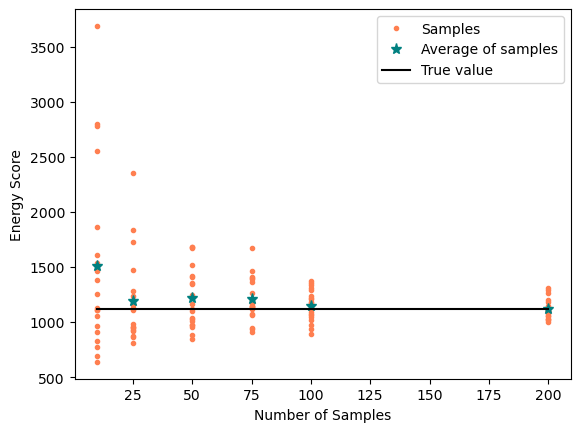

In [606]:
plt.plot(p.num_samples, p.energyscore,  '.',color= 'coral', label = 'Samples')
plt.plot([10,25,50,75,100,200], p.groupby('num_samples').mean().energyscore.values, '*', color='teal', markersize=8,
        label = 'Average of samples')

plt.plot(np.linspace(10,200,100), true.energyscore.values[0]*np.ones(100), 'k-', label = 'True value')



plt.xlabel('Number of Samples')
plt.ylabel('Energy Score')

plt.legend()
plt.show()

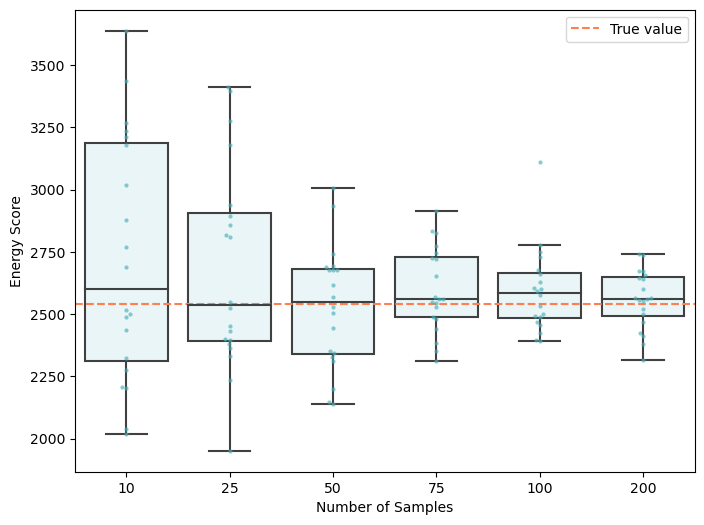

In [610]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.boxplot(x='num_samples', y = 'energyscore', data=p, order= [10,25,50,75,100,200], color = '#17B1BF',
           showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))
    
sns.swarmplot(x='num_samples', y='energyscore', data=p,order= [10,25,50,75,100,200],color = "#49AFB7",alpha = .65,
              size=3,orient="v")    



plt.axhline(y=true.energyscore.values[0], xmin=0, xmax=200,linestyle='--', color = 'coral',  
            label='True value')

plt.xlabel('Number of Samples')
plt.ylabel('Energy Score')

plt.legend()
plt.show()

In [611]:
samplesdf[samplesdf.num_samples ==25]

,Label,location,energyscore,target,abbreviation,location_name,population,num_samples
0,Scenario A,2,26.840247,hosp,AK,Alaska,731545,25
1,Scenario B,2,27.962895,hosp,AK,Alaska,731545,25
2,Scenario C,2,28.140891,hosp,AK,Alaska,731545,25
3,Scenario D,2,27.628470,hosp,AK,Alaska,731545,25
4,Scenario E,2,29.708248,hosp,AK,Alaska,731545,25
...,...,...,...,...,...,...,...,...
301,Scenario B,56,37.711469,hosp,WY,Wyoming,578759,25
302,Scenario C,56,36.239541,hosp,WY,Wyoming,578759,25
303,Scenario D,56,29.755324,hosp,WY,Wyoming,578759,25
304,Scenario E,56,41.473164,hosp,WY,Wyoming,578759,25


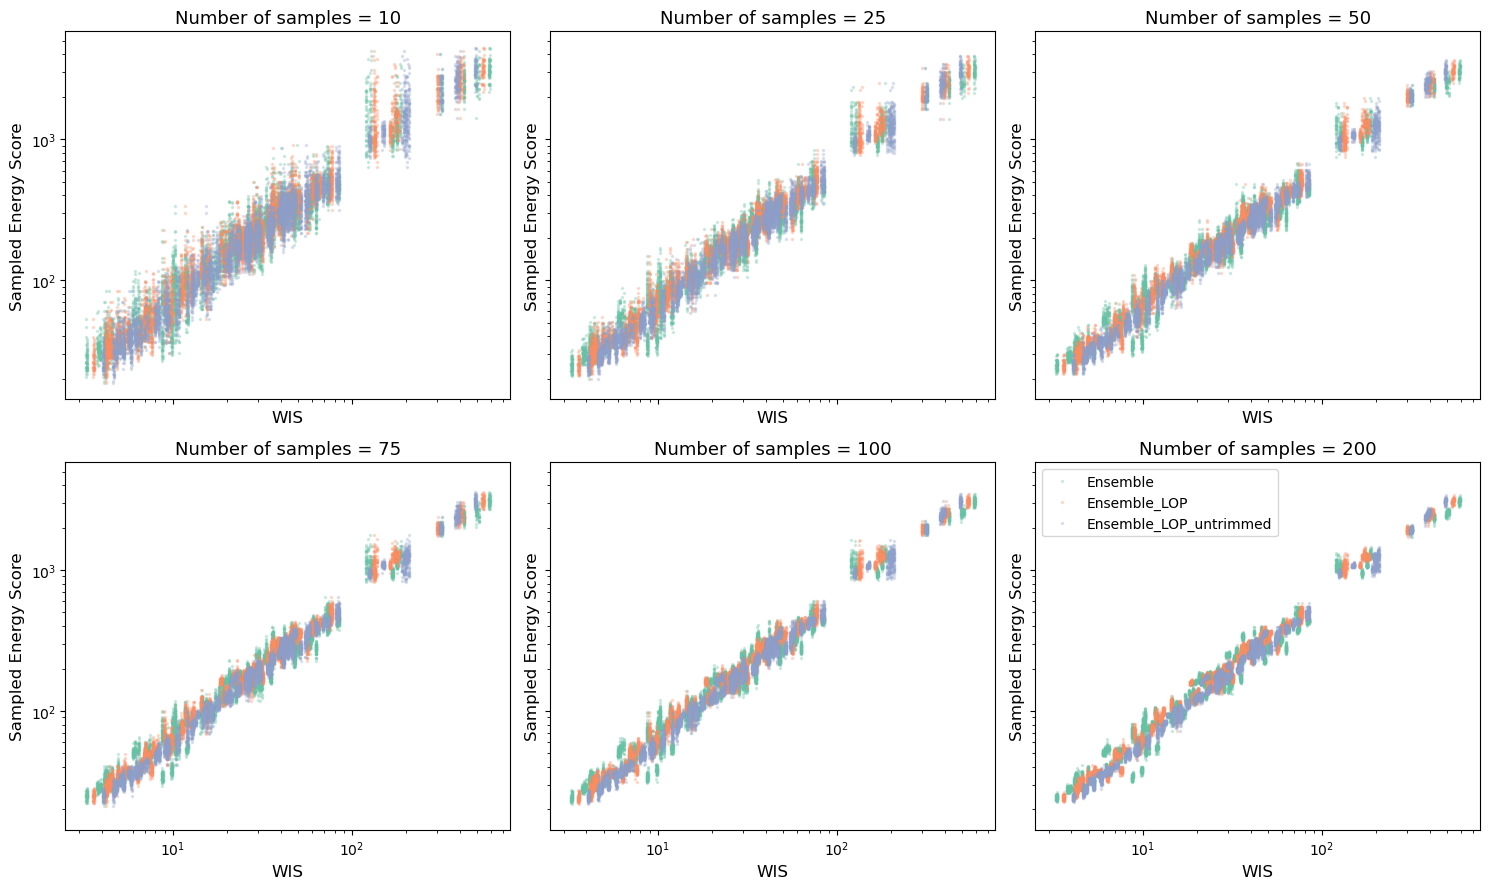

In [20]:
fig = plt.subplots(2,3, figsize=(15,9), sharex=True, sharey=True)

rd=17
target='hosp'

wisdf = pd.read_pickle(f'/Users/bay.c/Documents/GitHub/ensemble-square/megaround_wis_{target}_rd{rd}_scenarios.pkl') 
wisdf = wisdf.rename(columns={'Location':'location_name'})

cmap = plt.get_cmap('Set2', 8)
colors = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

n=1
for numsamp in [10,25, 50, 75, 100, 200]:

#numsamp = 10
    plt.subplot(2,3,n)
    ss = samplesdf[samplesdf.num_samples ==numsamp]

    i=0
    for model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
        wis = wisdf[wisdf.Model == model]

        esmod = ss.copy()

        allscores = pd.merge(esmod, wis, how='inner', on=['location_name', 'Label'])


        plt.loglog(allscores.WIS, allscores.energyscore,'.', alpha=.25,color = colors[i], label = model, markersize=3)
        i+=1
    n+=1

    plt.xlabel('WIS', fontsize=12)
    plt.ylabel('Sampled Energy Score', fontsize=12)
    plt.title('Number of samples = '+str(numsamp), fontsize=13)
plt.legend()
plt.tight_layout()

plt.show()